## Problem Statement

The goal of this analysis is to:

- Explore a custom synthetic HVAC dataset.
- Identify key patterns, trends, and anomalies in the data.
- Apply suitable preprocessing steps, including:
  - Handling missing values,
  - Normalization,
  - Outlier treatment.
- Compute core performance metrics such as:
  - Power consumption.
- Derive additional Key Performance Indicators (KPIs), if applicable, including:
  - HVAC efficiency,
  - Comfort scoring.




## Initial Data Exploration and Insights

<b>Import the Necessary Libraries Here</b>
<hr>

In [1]:
# Import necessary libraries
import pandas as pd              # Data manipulation and analysis
import numpy as np               # Numerical operations
import matplotlib.pyplot as plt  # Data visualization
import seaborn as sns            # Enhanced visualizations
import os
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from pmdarima import auto_arima


# Display settings for cleaner output
pd.set_option('display.max_columns', None)
sns.set(style="whitegrid")

<b> Data Exploration and Preprocessing </b>
<hr>

In [2]:
# Load the HVAC synthetic dataset
file_name = "hvac_synth.csv"
data_folder = 'data'
data_path = os.path.join(data_folder, file_name)
hvac_data = pd.read_csv(data_path)

# Preview the first few rows
hvac_data.head()

,timestamp,indoor_temp,supply_temp,hvac_control,airflow,power_usage,outdoor_temp,solar_radiation,occupancy,price,temp_error,cooling_demand,heating_demand,indoor_temp_savgol,supply_temp_savgol,outdoor_temp_savgol,temp_error_savgol,hvac_control_sma,airflow_sma,power_usage_sma,solar_radiation_sma,occupancy_sma,price_sma,cooling_demand_sma,heating_demand_sma,hvac_control_ema,airflow_ema,power_usage_ema,solar_radiation_ema,occupancy_ema,price_ema,cooling_demand_ema,heating_demand_ema,indoor_temp_robust,supply_temp_robust,outdoor_temp_robust,temp_error_robust,hvac_control_minmax,airflow_minmax,power_usage_minmax,solar_radiation_minmax,occupancy_minmax,price_minmax,cooling_demand_minmax,heating_demand_minmax
0,2020-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,0.537145,0.0,0.245344,0.160679,NaN,0.0,NaN,5.815322,-0.184678,-0.084103,-16.184678,1.0,0.901447,1496.661944,0.0,0.236733,0.163987,0.0,16.200316,NaN,NaN,NaN,0.0,0.245344,0.160679,0.0,NaN,2.501707,2.501695,-1.397942,2.501707,0.0,0.263284,0.012570,0.0,0.245344,0.453302,0.0,0.040649
1,2020-01-01 00:15:00,NaN,NaN,NaN,0.851765,1416.817844,1.245409,0.0,0.189761,0.163932,NaN,0.0,NaN,5.815322,-0.184678,2.362373,-16.184678,1.0,0.901447,1496.661944,0.0,0.236733,0.163987,0.0,16.200316,NaN,0.851765,1416.817844,0.0,0.213582,0.162538,0.0,NaN,2.501707,2.501695,-1.330230,2.501707,0.0,0.263284,0.012570,0.0,0.189761,0.487622,0.0,0.040649
2,2020-01-01 00:30:00,NaN,NaN,NaN,0.881392,1441.962322,3.160134,0.0,0.050169,0.182369,NaN,0.0,NaN,5.815322,-0.184678,3.536728,-16.184678,1.0,0.901447,1496.661944,0.0,0.236733,0.163987,0.0,16.200316,NaN,0.868695,1431.186117,0.0,0.142917,0.171114,0.0,NaN,2.501707,2.501695,-1.147177,2.501707,0.0,0.410525,0.104629,0.0,0.050169,0.682176,0.0,0.040649
3,2020-01-01 00:45:00,NaN,NaN,NaN,0.919333,1488.323327,5.058050,0.0,0.215428,0.169229,NaN,0.0,NaN,5.815322,-0.184678,3.720391,-16.184678,1.0,0.901447,1496.661944,0.0,0.236733,0.163987,0.0,16.200316,NaN,0.890593,1455.894100,0.0,0.169435,0.170424,0.0,NaN,2.501707,2.501695,-0.965730,2.501707,0.0,0.599093,0.274367,0.0,0.215428,0.543514,0.0,0.040649
4,2020-01-01 01:00:00,NaN,NaN,NaN,0.866692,1479.400149,1.322290,0.0,0.318407,0.163675,NaN,0.0,NaN,5.815322,-0.184678,2.620375,-16.184678,1.0,0.901447,1496.661944,0.0,0.214750,0.165470,0.0,16.200316,NaN,0.881852,1464.490598,0.0,0.218266,0.168212,0.0,NaN,2.501707,2.501695,-1.322880,2.501707,0.0,0.337469,0.241697,0.0,0.318407,0.484911,0.0,0.040649


In [3]:
print(f"Dataset shape: {hvac_data.shape}")


Dataset shape: (408000, 45)


> As I began exploring the dataset, I quickly noticed its scale: it contains **408,000 data points** spread across **45 features**. This richness offers a great opportunity to uncover meaningful patterns but also calls for careful preprocessing to manage the complexity.


In [4]:
hvac_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 408000 entries, 0 to 407999
Data columns (total 45 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   timestamp               408000 non-null  object 
 1   indoor_temp             405616 non-null  float64
 2   supply_temp             405615 non-null  float64
 3   hvac_control            407974 non-null  float64
 4   airflow                 407999 non-null  float64
 5   power_usage             407999 non-null  float64
 6   outdoor_temp            408000 non-null  float64
 7   solar_radiation         408000 non-null  float64
 8   occupancy               408000 non-null  float64
 9   price                   408000 non-null  float64
 10  temp_error              405616 non-null  float64
 11  cooling_demand          408000 non-null  float64
 12  heating_demand          405616 non-null  float64
 13  indoor_temp_savgol      408000 non-null  float64
 14  supply_temp_savgol  

> The `timestamp` column is currently stored as an object type and needs to be converted to a proper `datetime` format for accurate time-based analysis.


### Fix Incorrect Data Types for Accurate Analysis

In [5]:
# Make sure timestamp column is datetime
hvac_data['timestamp'] = pd.to_datetime(hvac_data['timestamp'])

# Determine the temporal coverage of the dataset
min_timestamp = hvac_data['timestamp'].min()
max_timestamp = hvac_data['timestamp'].max()

print(f"The dataset covers a period from {min_timestamp:%Y-%m-%d %H:%M:%S} to {max_timestamp:%Y-%m-%d %H:%M:%S}.")


The dataset covers a period from 2020-01-01 00:00:00 to 2031-08-20 23:45:00.


In [6]:
# Calculate time differences between consecutive rows
time_diffs = hvac_data['timestamp'].diff().dropna()

# View the time differences
print(time_diffs.value_counts())

timestamp
0 days 00:15:00    407999
Name: count, dtype: int64


### Identify columns with zero variance 

> The above analysis indicate that the HVAC data is recorded at **15-minute intervals**, spanning from **2020-01-01 00:00:00** to **2031-08-20 23:45:00**. This suggests a consistent and regular sampling frequency throughout the dataset.


In [7]:
# Identify columns with zero variance (i.e., constant values across all rows)
singleton_columns = hvac_data.columns[hvac_data.nunique() == 1]

# If any such columns exist, display and drop them
if not singleton_columns.empty:
    print(f"Removing the following zero-variance columns: {singleton_columns.tolist()}")
    hvac_data = hvac_data.drop(columns=singleton_columns)
else:
    print("No zero-variance columns found.")
   

Removing the following zero-variance columns: ['hvac_control', 'cooling_demand', 'hvac_control_sma', 'cooling_demand_sma', 'hvac_control_ema', 'cooling_demand_ema', 'hvac_control_minmax', 'cooling_demand_minmax']


> The above analysis indicates that the dataset contains variables with constant values across all rows. Such predictors provide no meaningful information for modeling and have therefore been removed to simplify the dataset.  
>  
> The removed variables are:  
> `hvac_control`, `cooling_demand`, `hvac_control_sma`, `cooling_demand_sma`, `hvac_control_ema`, `cooling_demand_ema`, `hvac_control_minmax`, `cooling_demand_minmax`.


### Analyze correlations between variables

In this dataset, some variables appear to be scaled versions of original features — for example, `power_usage` and `power_usage_minmax`. Identifying such strong correlations can help detect redundancy and simplify the feature space.


In [8]:
# Round the correlation matrix to 2 decimal places to avoid missing near-perfect correlations 
# due to floating-point precision (e.g., 0.999999 ≈ 1.0).
corr_matrix = np.round(hvac_data.corr().abs(), 2)


# Select the upper triangle of the correlation matrix to avoid duplicate pairs
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Find all variable pairs with perfect correlation (correlation = 1.0)
perfect_corr_pairs = [
    (col1, col2) 
    for col1 in upper.columns 
    for col2 in upper.index 
    if upper.loc[col2, col1] == 1.0
]

# Display the pairs
if perfect_corr_pairs:
    print("Perfectly correlated variable pairs:")
    for pair in perfect_corr_pairs:
        print(f"{pair[0]} <--> {pair[1]}")
else:
    print("No perfectly correlated variable pairs found.")


Perfectly correlated variable pairs:
temp_error <--> indoor_temp
heating_demand <--> indoor_temp
heating_demand <--> temp_error
indoor_temp_savgol <--> indoor_temp
indoor_temp_savgol <--> temp_error
indoor_temp_savgol <--> heating_demand
supply_temp_savgol <--> supply_temp
temp_error_savgol <--> indoor_temp
temp_error_savgol <--> temp_error
temp_error_savgol <--> heating_demand
temp_error_savgol <--> indoor_temp_savgol
indoor_temp_robust <--> indoor_temp
indoor_temp_robust <--> temp_error
indoor_temp_robust <--> heating_demand
indoor_temp_robust <--> indoor_temp_savgol
indoor_temp_robust <--> temp_error_savgol
supply_temp_robust <--> supply_temp
supply_temp_robust <--> supply_temp_savgol
outdoor_temp_robust <--> outdoor_temp
temp_error_robust <--> indoor_temp
temp_error_robust <--> temp_error
temp_error_robust <--> heating_demand
temp_error_robust <--> indoor_temp_savgol
temp_error_robust <--> temp_error_savgol
temp_error_robust <--> indoor_temp_robust
airflow_minmax <--> airflow
power

> Correlation analysis reveals that the dataset contains several pairs of perfectly correlated variables (correlation = ±1). This indicates redundancy, as these features convey identical information. To ensure model robustness and avoid multicollinearity—especially in models sensitive to feature independence—it is important to remove one variable from each perfectly correlated pair.

> Additionally, the dataset includes both original variables and their scaled versions (e.g., min-max scaled features). Keeping both may lead to information duplication and bias model learning. We should retain only one version of each feature based on the modeling needs and scaling requirements.


---

## 🚩 Why Are There So Many Perfectly Correlated Variables in This Dataset?

Instead of just removing these variables, **let’s dive deeper to understand the underlying reasons!**

Exploring these correlations can reveal important insights about data preprocessing, feature engineering, or measurement methods used.

---


> Most variables are multiple transformed versions of the same original features, including **Savitzky-Golay (savgol), Simple Moving Average (sma), Exponential Moving Average (ema), Robust filtering, and Min-Max scaling (minmax)**.  
>  
> Let’s categorize these transformations to gain a clearer understanding of the dataset!


In [9]:
# Original variables (raw measurements)
original_variables = [
    'timestamp', 'indoor_temp', 'supply_temp', 'outdoor_temp', 'temp_error', 'airflow', 'power_usage', 'solar_radiation', 'occupancy', 'price', 'heating_demand'
]

# Variables smoothed with Savitzky-Golay filter (smoothing + shape-preserving)
savgol_variables = [
    'indoor_temp_savgol', 'supply_temp_savgol', 'outdoor_temp_savgol', 'temp_error_savgol'
]

# Variables processed with Robust filter (resistant to outliers/spikes)
robust_variables = [
    'indoor_temp_robust', 'supply_temp_robust', 'outdoor_temp_robust', 'temp_error_robust']

# Variables smoothed with Simple Moving Average (SMA)
sma_variables = [
    'airflow_sma', 'power_usage_sma', 'solar_radiation_sma', 'occupancy_sma', 'price_sma', 'heating_demand_sma'
]

# Variables smoothed with Exponential Moving Average (EMA)
ema_variables = [
    'airflow_ema', 'power_usage_ema', 'solar_radiation_ema', 'occupancy_ema', 'price_ema', 'heating_demand_ema'
]

# Variables scaled with Min-Max normalization
minmax_variables = [
    'airflow_minmax', 'power_usage_minmax', 'solar_radiation_minmax', 'occupancy_minmax', 'price_minmax', 'heating_demand_minmax'
]


### Exploring the Unprocessed (Original) Features

In [10]:
# Subset the dataset to include only the original features for EDA
hvac_raw_data = hvac_data[original_variables]

In [11]:
hvac_raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 408000 entries, 0 to 407999
Data columns (total 11 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   timestamp        408000 non-null  datetime64[ns]
 1   indoor_temp      405616 non-null  float64       
 2   supply_temp      405615 non-null  float64       
 3   outdoor_temp     408000 non-null  float64       
 4   temp_error       405616 non-null  float64       
 5   airflow          407999 non-null  float64       
 6   power_usage      407999 non-null  float64       
 7   solar_radiation  408000 non-null  float64       
 8   occupancy        408000 non-null  float64       
 9   price            408000 non-null  float64       
 10  heating_demand   405616 non-null  float64       
dtypes: datetime64[ns](1), float64(10)
memory usage: 34.2 MB


In [12]:
# find correlations bewtween original features
# Round the correlation matrix to 2 decimal places to avoid missing near-perfect correlations 
# due to floating-point precision (e.g., 0.999999 ≈ 1.0).
corr_matrix = np.round(hvac_raw_data.corr().abs(), 2)


# Select the upper triangle of the correlation matrix to avoid duplicate pairs
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Find all variable pairs with perfect correlation (correlation = 1.0)
perfect_corr_pairs = [
    (col1, col2) 
    for col1 in upper.columns 
    for col2 in upper.index 
    if upper.loc[col2, col1] == 1.0
]

# Display the pairs
if perfect_corr_pairs:
    print("Perfectly correlated variable pairs:")
    for pair in perfect_corr_pairs:
        print(f"{pair[0]} <--> {pair[1]}")
else:
    print("No perfectly correlated variable pairs found.")

Perfectly correlated variable pairs:
temp_error <--> indoor_temp
heating_demand <--> indoor_temp
heating_demand <--> temp_error


> temp_error, heating_demand, and indoor_temp exhibit perfect or near-perfect correlations.
Let’s dig deeper to understand the underlying relationships and dependencies among these variables.

In [13]:
hvac_raw_data[['temp_error', 'heating_demand', 'indoor_temp']].tail(10)

,temp_error,heating_demand,indoor_temp
407990,-16.896892,16.896892,5.103108
407991,-16.951599,16.951599,5.048401
407992,-16.941959,16.941959,5.058041
407993,-16.936464,16.936464,5.063536
407994,-17.000000,17.000000,5.000000
407995,-17.000000,17.000000,5.000000
407996,-16.986922,16.986922,5.013078
407997,-16.956582,16.956582,5.043418
407998,-17.000000,17.000000,5.000000
407999,-17.000000,17.000000,5.000000


>🔍 The heating_demand and temp_error variables appear to be negatively proportional — potentially exact opposites (i.e., one is the negative of the other).
Let’s verify if this relationship holds mathematically.

In [14]:
# Check if 'heating_demand' is exactly the negative of 'temp_error', including NaN alignment
comparison = hvac_data['heating_demand'].equals(-hvac_data['temp_error'])

print(f"Are 'heating_demand' and 'temp_error' perfectly negatively correlated (negatives of each other)?: {comparison}\n")

# If true, drop 'temp_error' to avoid redundancy
if comparison:
    hvac_raw_data = hvac_raw_data.drop(columns=['temp_error'])
    print("'temp_error' column dropped due to perfect negative correlation with 'heating_demand'.")


Are 'heating_demand' and 'temp_error' perfectly negatively correlated (negatives of each other)?: True

'temp_error' column dropped due to perfect negative correlation with 'heating_demand'.


In [15]:
# Drop 'indoor_temp' variable since it is perfectly correlated (correlation = 1) with 'heating_demand'.
# These variables are likely derived from each other, so keeping both is redundant.
hvac_raw_data = hvac_raw_data.drop(columns=['indoor_temp'])

In [16]:
hvac_raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 408000 entries, 0 to 407999
Data columns (total 9 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   timestamp        408000 non-null  datetime64[ns]
 1   supply_temp      405615 non-null  float64       
 2   outdoor_temp     408000 non-null  float64       
 3   airflow          407999 non-null  float64       
 4   power_usage      407999 non-null  float64       
 5   solar_radiation  408000 non-null  float64       
 6   occupancy        408000 non-null  float64       
 7   price            408000 non-null  float64       
 8   heating_demand   405616 non-null  float64       
dtypes: datetime64[ns](1), float64(8)
memory usage: 28.0 MB


> I'm curious whether the missing (NaN) values for the supply_temp occur consecutively, since this is time series data. If the missing values are confined to a specific time window, we might consider dropping that period altogether.

In [17]:
# Get the index positions (as integers) where any column has NaN
nan_indices = hvac_raw_data[hvac_raw_data['supply_temp'].isnull()].index

# Check if they form a continuous sequence
is_block = all((nan_indices[i] + 1 == nan_indices[i+1]) for i in range(len(nan_indices) - 1))

print("NaN values are in a continuous block:" , is_block)

if is_block:
    hvac_raw_data.dropna(subset=['supply_temp'], inplace=True)


NaN values are in a continuous block: True


In [18]:
hvac_raw_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 405615 entries, 2385 to 407999
Data columns (total 9 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   timestamp        405615 non-null  datetime64[ns]
 1   supply_temp      405615 non-null  float64       
 2   outdoor_temp     405615 non-null  float64       
 3   airflow          405615 non-null  float64       
 4   power_usage      405615 non-null  float64       
 5   solar_radiation  405615 non-null  float64       
 6   occupancy        405615 non-null  float64       
 7   price            405615 non-null  float64       
 8   heating_demand   405615 non-null  float64       
dtypes: datetime64[ns](1), float64(8)
memory usage: 30.9 MB


> **Observation:**  
After dropping the null values in the `supply_temp` column, all rows containing null values were removed from the dataset. This suggests that the missing values in `heating_demand`, `airflow`, and `power_usage` likely occurred at the same timestamps as those in `supply_temp`.

> Now, the dataset is free of missing values and ready for exploring relationships between the variables.


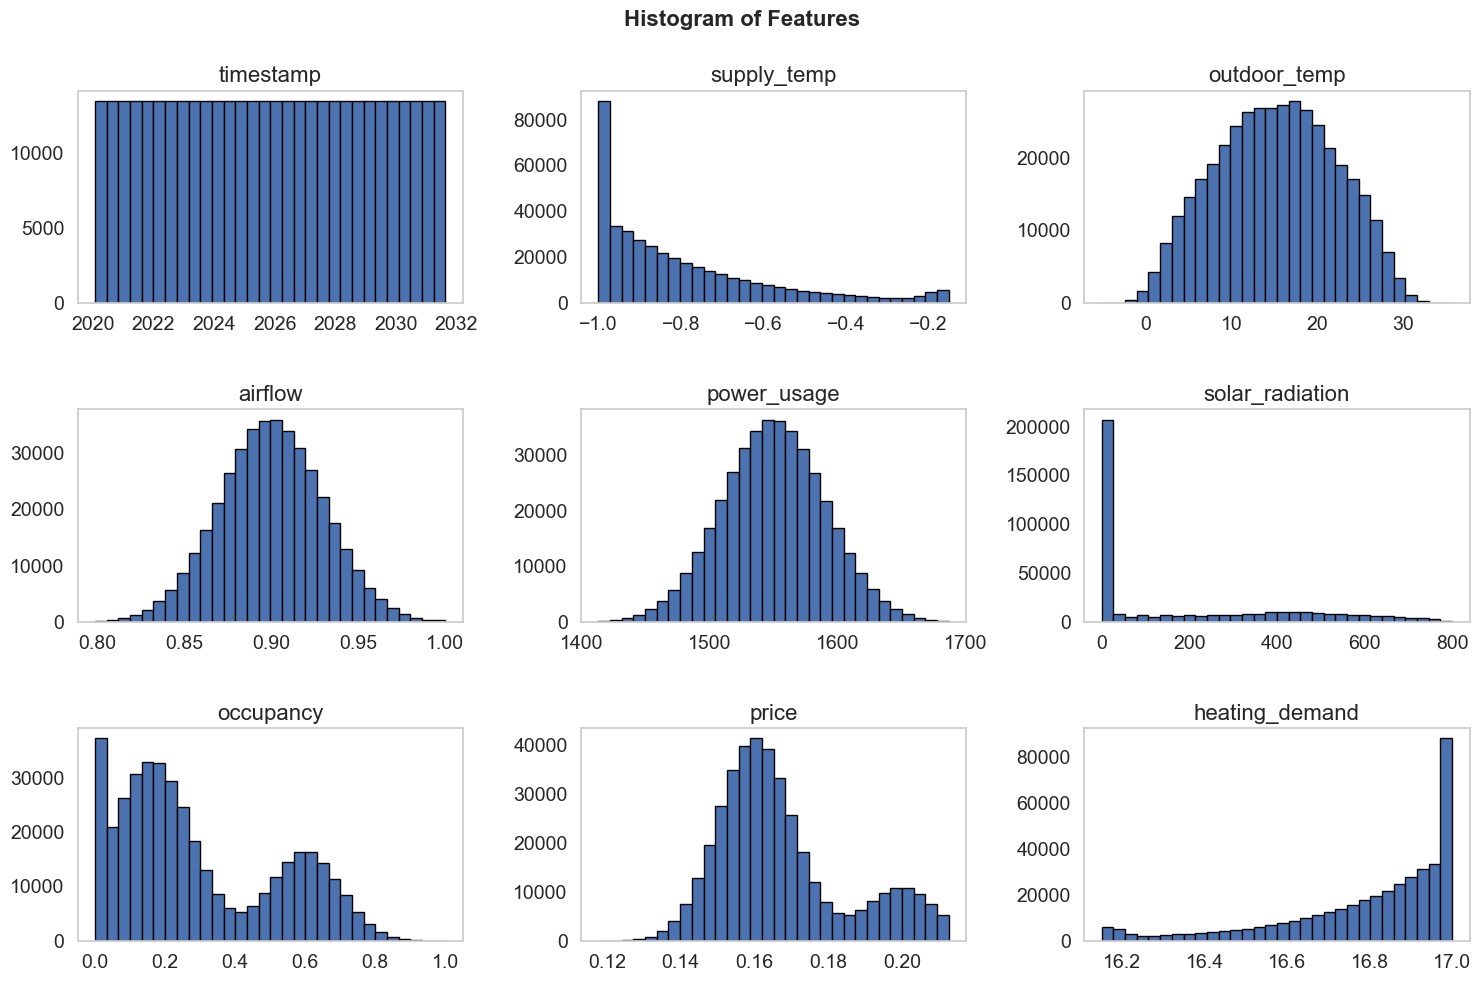

In [19]:
# Plot histograms for all features in hvac_raw_data
axes = hvac_raw_data.hist(bins=30, figsize=(15, 10), grid=False, edgecolor='black')

plt.suptitle("Histogram of Features", fontsize=16, fontweight='bold')
for ax in axes.flatten():
    ax.title.set_fontsize(16)
    ax.tick_params(axis='x', labelsize=14)
    ax.tick_params(axis='y', labelsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.98])  # Adjust layout to fit suptitle
plt.subplots_adjust(hspace=0.5)  # More space between rows
plt.show()


> The **occupancy** variable changes between 0 and 1, indicating it is likely **scaled** (e.g., representing percentage or probability).
>
> The **supply temperature** ranges from approximately -0.2 to 1. Since the units are **not specified** in the original dataset, this range suggests one of two possibilities:
> - The values are **scaled or normalized**, or
> - The data is in a **unitless or transformed format**, rather than in standard temperature units (°C or °F).
>
> Either way, the values appear **very low**, and further clarification or data documentation would help interpret them accurately.


## Which model should we use (time series or classic machine learning models e.g. linear regression, gradient-descent)

Before building a predictive model for target variable (power consumption), it's important to understand the behavior of the target variable over time. I would like to understand if the outcome variable shows any autocorrelation or observations are independent from each other).  Specifically, I look for the following key characteristics:

- **Trend**: Does power consumption generally increase or decrease over time?
- **Seasonality**: Are there repeating patterns at regular intervals (e.g., daily, weekly, yearly)?
- **Autocorrelation**: Does the current value of power consumption depend on its previous values?

Identifying these components helps determine the appropriate modeling approach. For example, if there is an autocorrelation, i could not apply linear regression as it assumes observations are independent (no autocorrelation)

###  Modeling Guidance Based on Observations

- If **seasonality** is present in power consumption:  
  ➤ Consider using models like **SARIMA**, **Prophet**, **seasonal decomposition**, or **XGBoost** with engineered time-based features.

- If the series is **non-stationary** (e.g., due to  presence of trend (upward, downward, cyclic etc.) or  changing variance):  
  ➤ Apply **differencing** or **transformations** (e.g., log or power transformations) to stabilize the series before modeling.

Understanding these patterns is crucial for building accurate and robust time series forecasting models.


In [20]:
# Set 'timestamp' as the DataFrame index for time-series operations
hvac_raw_data.set_index('timestamp', inplace=True)

<Figure size 1500x800 with 0 Axes>

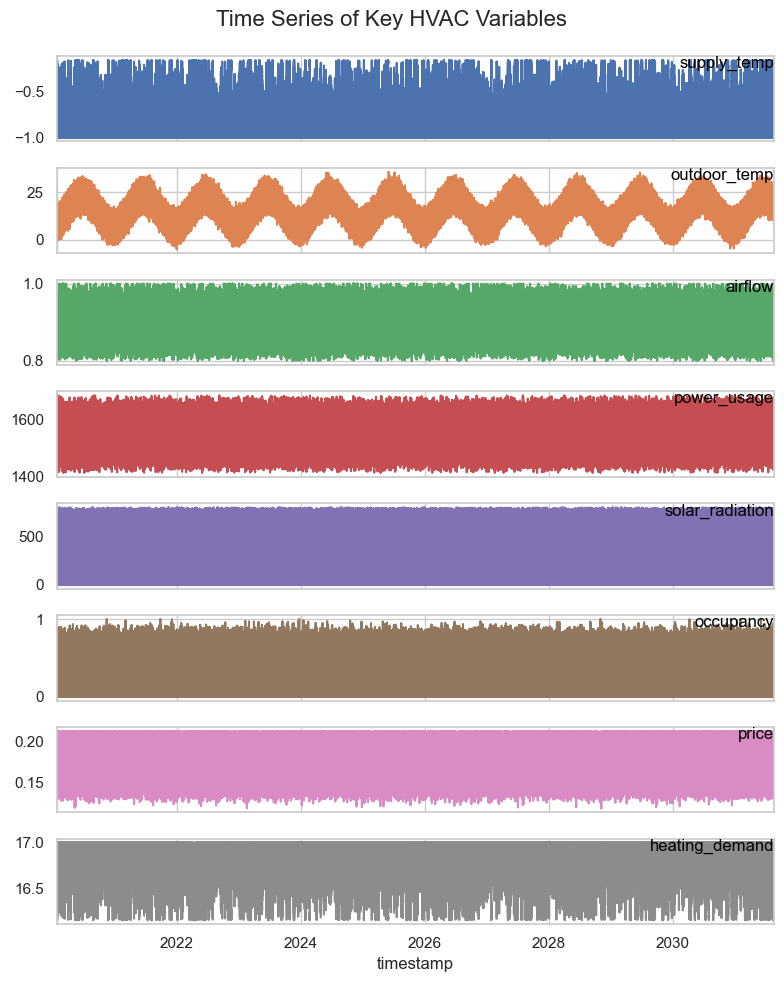

In [21]:
# Time Series Plot of Predictors and Outcome Variable
plt.figure(figsize=(15, 8))
axes = hvac_raw_data.plot(subplots=True, figsize=(8, 10), legend=False)

# Add label to the top-right of each subplot
for ax in axes:
    label = ax.get_ylabel() or ax.get_title() or ax.get_legend_handles_labels()[1][0]  # Fallback for label
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    ax.text(xlim[1], ylim[1], label, fontsize=12,
            ha='right', va='top', color='black')

plt.suptitle("Time Series of Key HVAC Variables", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.99])  # Reserve space for suptitle
plt.show()


> **Seasonality in Outdoor Temperature:**  
The outdoor temperature shows clear yearly seasonality — it rises during the first half of the year and falls during the second half. However, this seasonal pattern is not immediately visible in other variables such as `heating_demand`. To better understand potential seasonal effects in those variables, we may need to analyze the data at a different time granularity (e.g., monthly or weekly averages).


## Next Steps: Aggregating to Daily

In the next steps, I will aggregate the data to a **daily** level.

- **Outdoor temperature** affects HVAC use most noticeably on a **daily basis** — think of hot vs. cold days.
- **15-minute data** is too granular for initial seasonal exploration (too noisy).
- **Daily averages** smooth out noise while still preserving key seasonal patterns.


In [22]:
#Resample to Daily Means to Check Seasonality
daily_data = hvac_raw_data.resample('D').mean() # Daily mean shows the average power during the day (in kW).
#daily_data = hvac_raw_data.resample('D').sum() * 0.25 #  how much energy was actually used

In [23]:
# Generate a list of year-start dates to use as x-axis tick marks for clarity
years = pd.date_range(start='2020-01-01', end='2033-01-01', freq='YS')

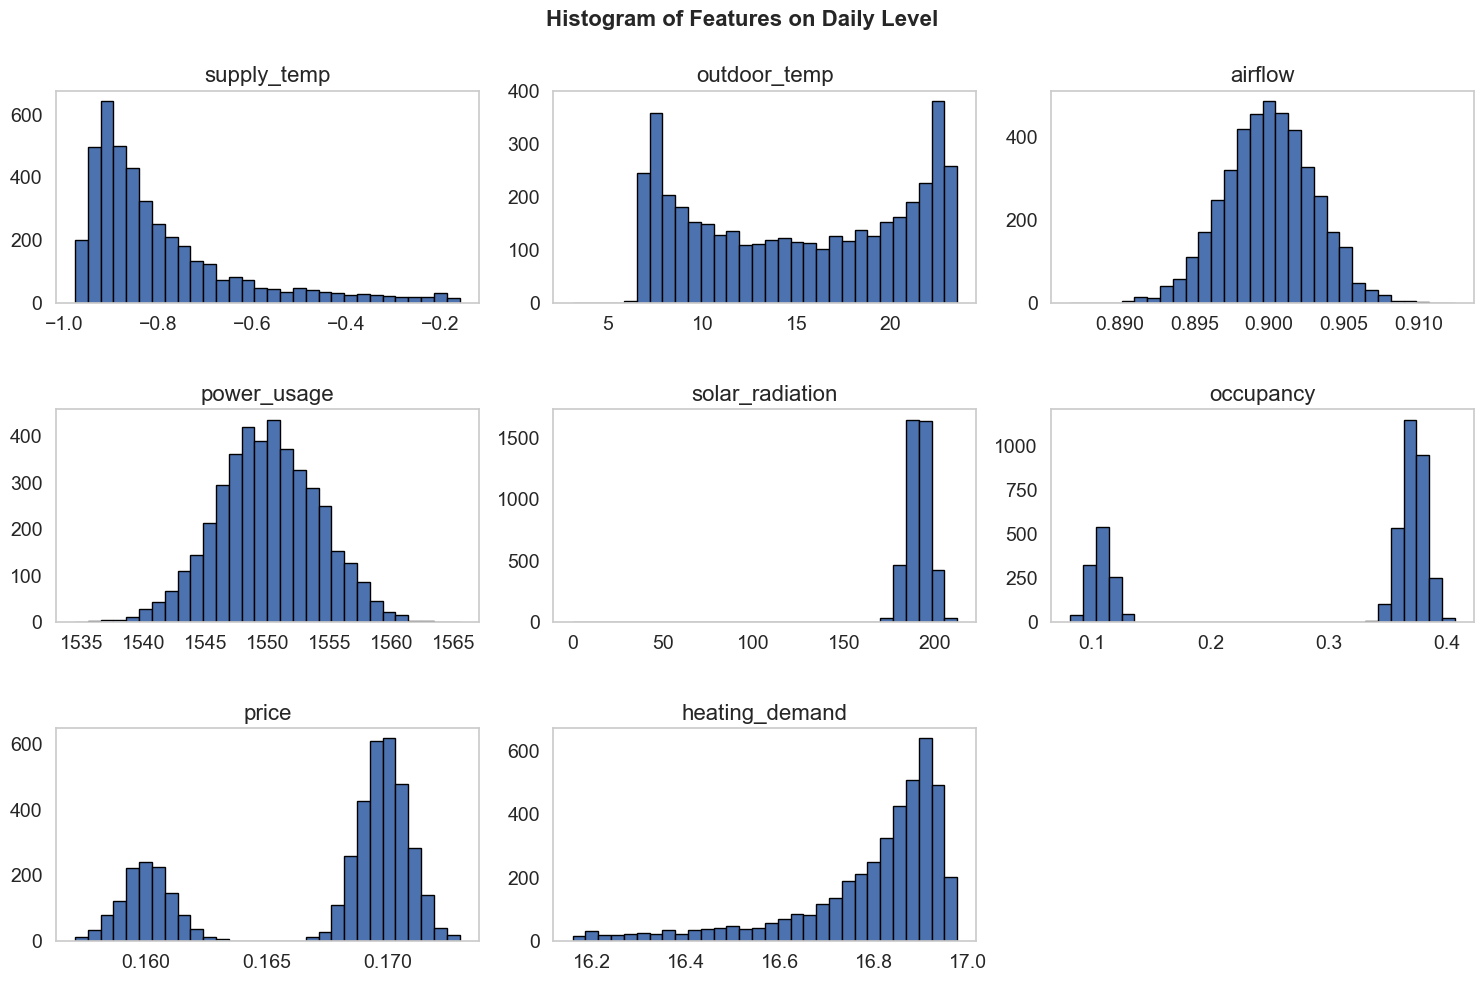

In [24]:
# Plot histograms for all features in daily aggregation of hvac_raw_data
axes = daily_data.hist(bins=30, figsize=(15, 10), grid=False, edgecolor='black')

plt.suptitle("Histogram of Features on Daily Level", fontsize=16, fontweight='bold')
for ax in axes.flatten():
    ax.title.set_fontsize(16)
    ax.tick_params(axis='x', labelsize=14)
    ax.tick_params(axis='y', labelsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.98])  # Adjust layout to fit suptitle
plt.subplots_adjust(hspace=0.5)  # More space between rows
plt.show()

### Explore Power Usage Seasonality  
Given the strong yearly seasonality observed in outdoor temperature, I will investigate whether power usage exhibits a similar seasonal pattern.

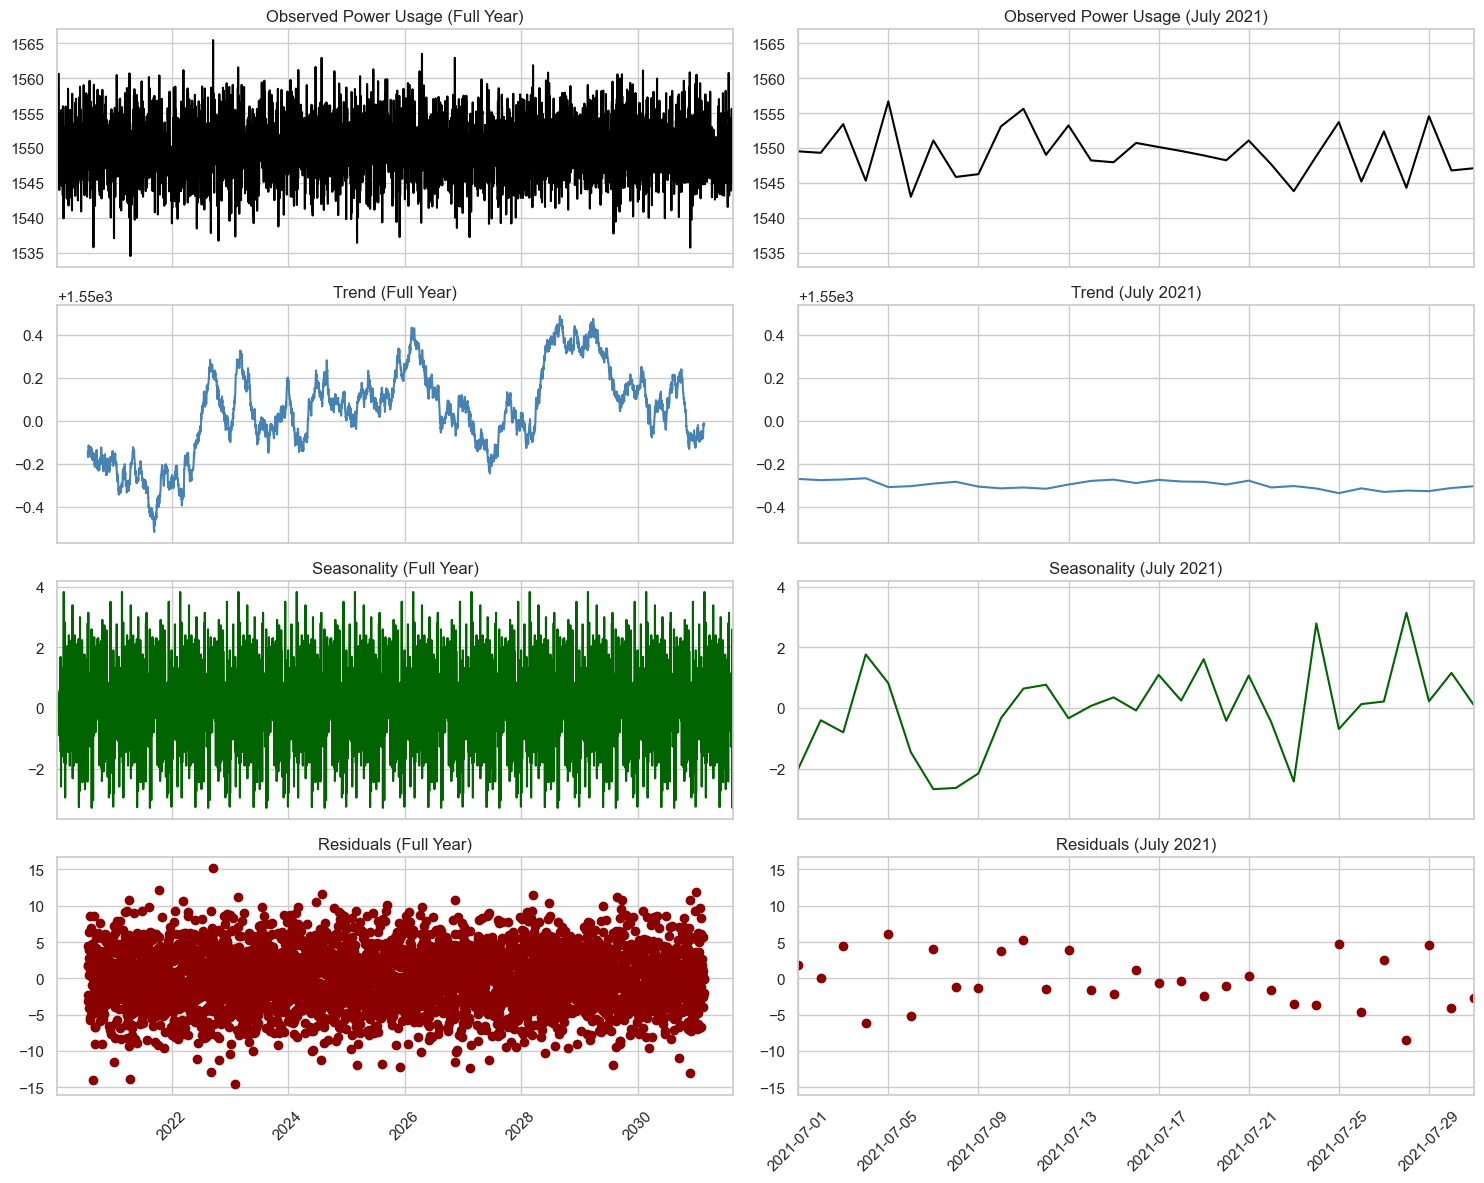

In [25]:
# Decompose power usage time series
decomposition = seasonal_decompose(daily_data['power_usage'], model='additive', period=365)

observed = decomposition.observed
trend = decomposition.trend
seasonal = decomposition.seasonal
resid = decomposition.resid

# Define time ranges
full_range_start = min(daily_data.index) - pd.Timedelta(days=10)    # Start of full time range
full_range_end = max(daily_data.index)     # End of full time range
zoom_start = pd.Timestamp('2021-07-01')         # Start of zoomed month
zoom_end = pd.Timestamp('2021-07-31')           # End of zoomed month

# Create subplot layout: 4 rows (Observed, Trend, Seasonal, Residual), 2 columns (Full Year, July)
fig, axes = plt.subplots(4, 2, figsize=(15, 12), sharex='col')

# Plot: Observed
axes[0, 0].plot(observed, color='black')
axes[0, 0].set_xlim(full_range_start, full_range_end)
axes[0, 0].set_title('Observed Power Usage (Full Year)')

axes[0, 1].plot(observed, color='black')
axes[0, 1].set_xlim(zoom_start, zoom_end)
axes[0, 1].set_title('Observed Power Usage (July 2021)')

# Plot: Trend
axes[1, 0].plot(trend, color='steelblue')
axes[1, 0].set_xlim(full_range_start, full_range_end)
axes[1, 0].set_title('Trend (Full Year)')

axes[1, 1].plot(trend, color='steelblue')
axes[1, 1].set_xlim(zoom_start, zoom_end)
axes[1, 1].set_title('Trend (July 2021)')

# Plot: Seasonal
axes[2, 0].plot(seasonal, color='darkgreen')
axes[2, 0].set_xlim(full_range_start, full_range_end)
axes[2, 0].set_title('Seasonality (Full Year)')

axes[2, 1].plot(seasonal, color='darkgreen')
axes[2, 1].set_xlim(zoom_start, zoom_end)
axes[2, 1].set_title('Seasonality (July 2021)')

# Plot: Residuals
axes[3, 0].scatter(resid.index, resid, color='darkred')
axes[3, 0].set_xlim(full_range_start, full_range_end)
axes[3, 0].set_title('Residuals (Full Year)')

axes[3, 1].scatter(resid.index, resid, color='darkred')
axes[3, 1].set_xlim(zoom_start, zoom_end)
axes[3, 1].set_title('Residuals (July 2021)')

# Rotate x-ticks and adjust layout
for ax in axes.flatten():
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


#### Comment
### Trend Component (Approximately 1549.5 to 1550.5)  
The trend values vary narrowly between approximately 1549.5 and 1550.5, indicating a stable long-term pattern with no significant upward or downward movement over the period from 2020 to 2033.

### Seasonal Component (-2.5 to 2.5)  
Power usage changes a little throughout the year, going up or down by about 2.5 units. This means there is a small seasonal effect (like slightly higher use in winter or summer), but overall, the power demand stays fairly steady.

### Residual Component (-10 to 10)  
The residuals are the random ups and downs that the trend and seasonal parts don’t explain. Since these vary more (between -10 and 10), it means other factors also affect power usage, such as:  
- Daily or weekly usage patterns not captured by yearly seasonality  
- Changes in occupancy or equipment use  
- Measurement errors or unusual events

###  Stationarity Analysis of Power Usage

In [26]:
# Test for stationarity with ADF test
adf_result = adfuller(daily_data['power_usage'])
print("ADF Statistic:", adf_result[0])
print("p-value:", adf_result[1])
for key, value in adf_result[4].items():
    print(f'Critical Value {key}: {value}')

ADF Statistic: -44.8586876359219
p-value: 0.0
Critical Value 1%: -3.4318990715933504
Critical Value 5%: -2.8622244944629607
Critical Value 10%: -2.5671343619814087


### Comment
The **Augmented Dickey-Fuller (ADF) test** was applied to the daily **power usage** variable in the HVAC dataset.  
The test returned a **p-value of 0.0**, which is well below the commonly used threshold of **0.05**.

This result allows us to **reject the null hypothesis** of a unit root, indicating that the **power usage data is stationary**.

In practical terms, this means the statistical properties of power usage—such as its **mean and variance**—remain **stable over time**, making it suitable for **time series modeling techniques** that assume stationarity, such as **ARIMA**.


### Diagnostic Tests for Autocorrelation

Autocorrelation refers to the correlation of a time series with its own past values. Detecting it is crucial for time series modeling.

#### 1. **Autocorrelation Function (ACF) Plot**
- Visual tool to identify autocorrelation at different lags.
- Significant spikes outside the confidence band suggest autocorrelation.

#### 2. **Partial Autocorrelation Function (PACF) Plot**
- Shows the correlation of a variable with its lags after removing the effect of intermediate lags.
- Helps determine the order of an autoregressive (AR) model.

#### 3. **Ljung-Box Test**
- Statistical test for overall randomness based on multiple lags.
- Null hypothesis: no autocorrelation up to a certain lag.
- A low p-value (< 0.05) suggests autocorrelation is present.


---

These tests help determine whether residuals from a model are independent—an assumption in many time series models.


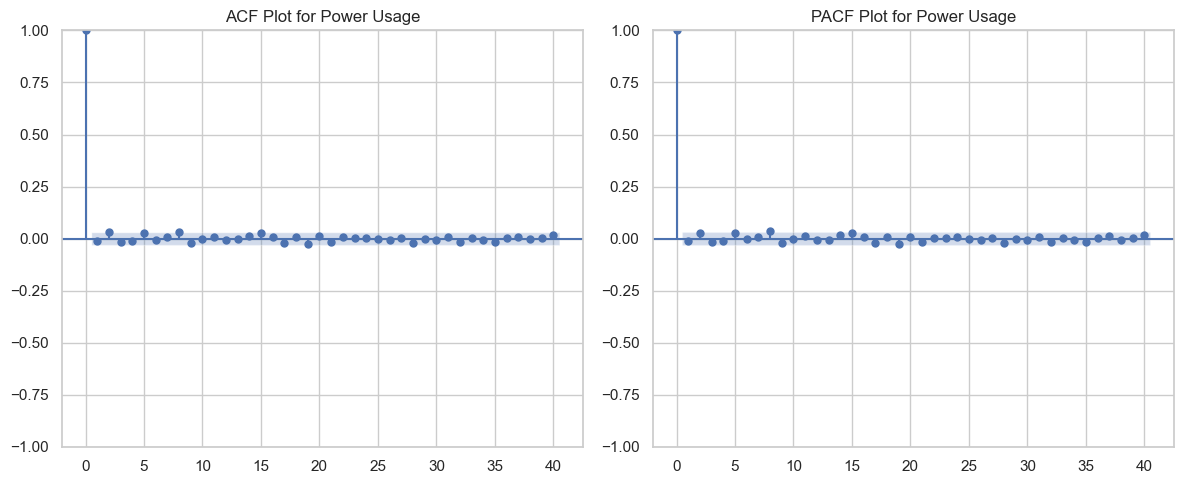

In [27]:
# Create subplots: 1 row, 2 columns for ACF and PACF
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot ACF
plot_acf(daily_data['power_usage'], lags=40, ax=axes[0])
axes[0].set_title('ACF Plot for Power Usage')

# Plot PACF
plot_pacf(daily_data['power_usage'], lags=40, method='ywm', ax=axes[1])
axes[1].set_title('PACF Plot for Power Usage')

plt.tight_layout()
plt.show()


In [28]:
# Ljung-Box test (up to lag 40)
ljung_box_result = acorr_ljungbox(daily_data['power_usage'], lags=[40], return_df=True)
print("Ljung-Box Test Result (lag=40):")
print(ljung_box_result)


Ljung-Box Test Result (lag=40):
     lb_stat  lb_pvalue
40  34.87208   0.699994


### Autocorrelation Analysis Summary

PACF, ACF, and the Ljung-Box test indicate **no significant autocorrelation or partial autocorrelation** in the data.  

A lag of **40** was chosen to examine correlations up to 40 time points.  

The Ljung-Box test returned a **p-value of 0.70**, which is well above the 0.05 threshold, suggesting that the null hypothesis of no autocorrelation cannot be rejected.


### Explore Outdoor Temperature Seasonality

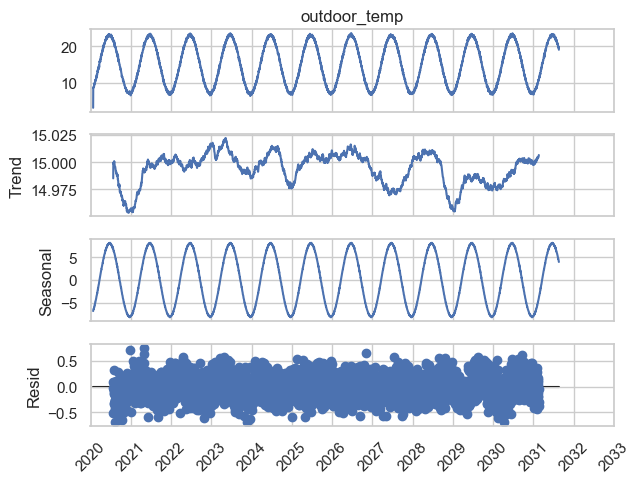

In [29]:
# Perform a time series decomposition into the trend, seasonality, and residuals¶
decomposition_outdoor_temp = seasonal_decompose(daily_data['outdoor_temp'], model='additive', period=365)
decomposition_outdoor_temp.plot()

plt.xticks(ticks=years, labels=[str(year.year) for year in years], rotation=45)
plt.show()



#### Comment
**Trend Component** (14.975 to 15.025)
- This narrow range suggests **little to no long-term upward or downward trend** (yearly) in the average outdoor temperature.
- It's effectively flat, indicating that the **yearly average temperature remains stable** over time.

**Seasonal Component** (-5 to +5, sinusoidal shape)
- This indicates a **strong yearly seasonality** — temperature rises and falls in a predictable, wave-like pattern.
- The sinusoidal shape reflects the **cyclical nature of seasons** (e.g., warmer in summer, colder in winter).
- The amplitude (±5) shows the **degree of fluctuation** around the average temperature across the year. The outdoor temperature is typically 5 degrees higher than average during the warmest part of the year. It is also 5 degrees lower than average during the coldest part of the year.

**Residual Component**(-0.5 to +0.5)
- The residuals capture the **random noise** not explained by the trend or seasonal components.
- The relatively narrow range (±0.5) suggests that the model has captured most of the structure in the data.
- These small fluctuations indicate **low variability** beyond the identified trend and seasonality — a sign of a **good decomposition fit**.




### Explore Supply Temperature Seasonality

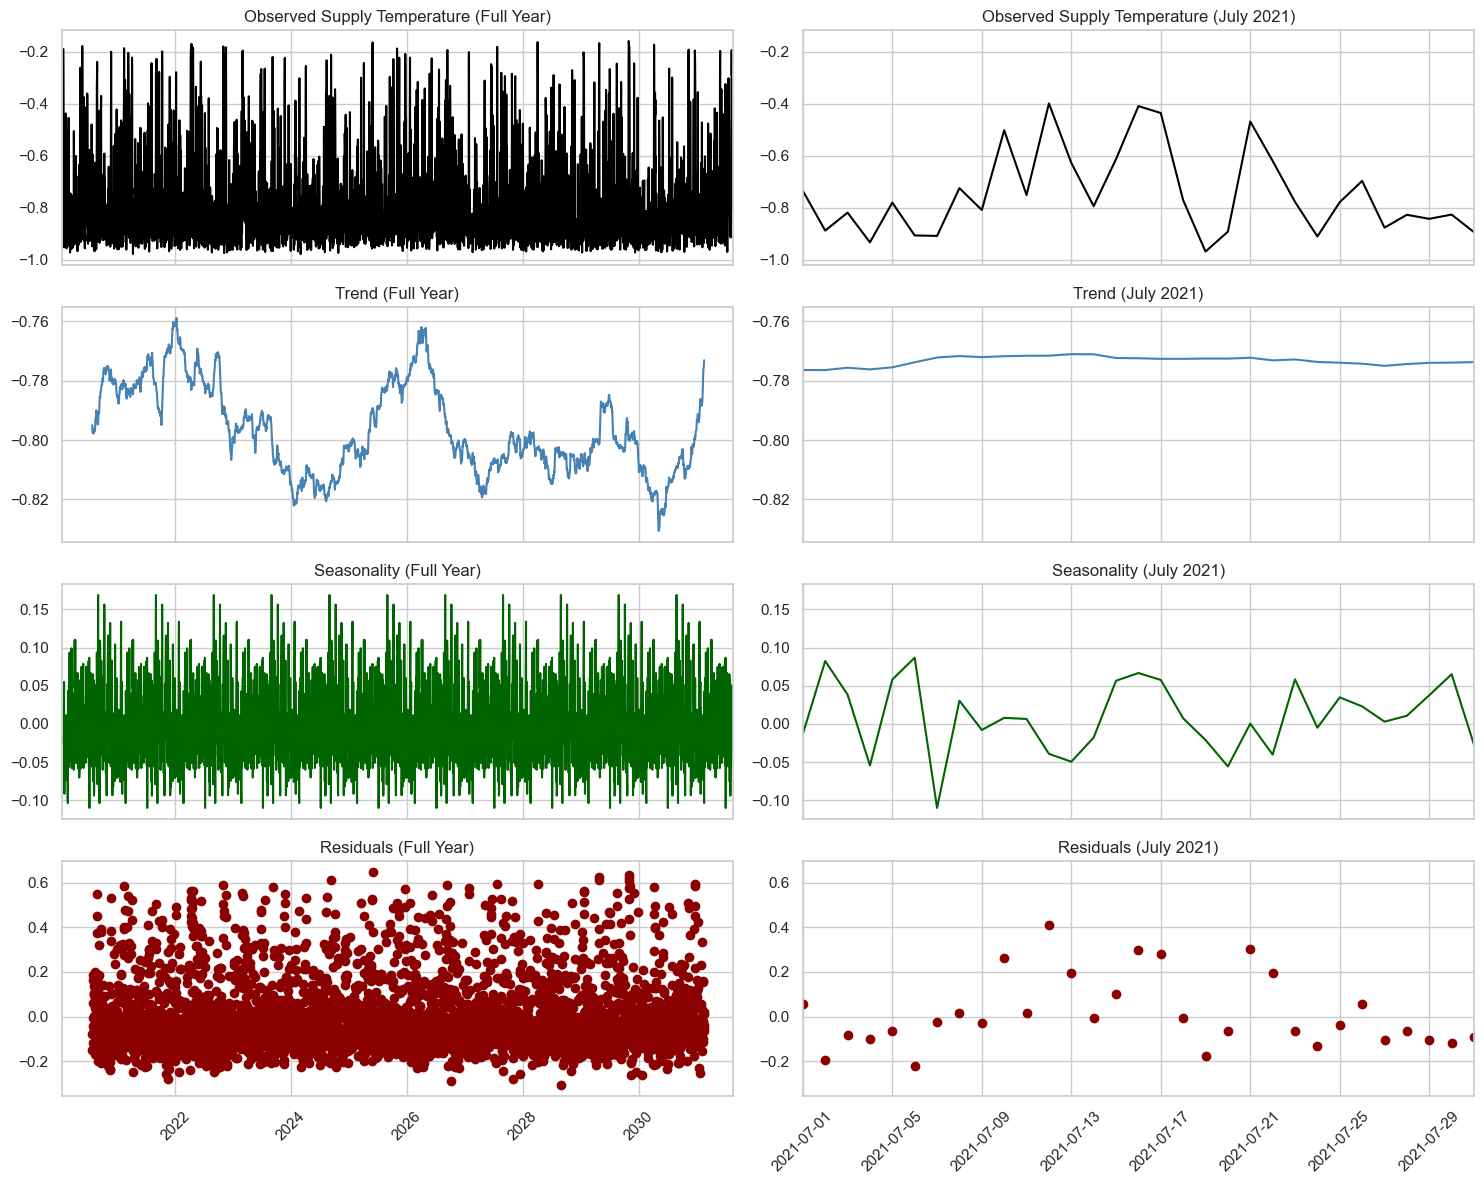

In [30]:
# Decompose supply temperature time series
decomposition = seasonal_decompose(daily_data['supply_temp'], model='additive', period=365)

observed = decomposition.observed
trend = decomposition.trend
seasonal = decomposition.seasonal
resid = decomposition.resid

# Define time ranges
full_range_start = min(daily_data.index) - pd.Timedelta(days=10)    # Start of full time range
full_range_end = max(daily_data.index)     # End of full time range
zoom_start = pd.Timestamp('2021-07-01')         # Start of zoomed month
zoom_end = pd.Timestamp('2021-07-31')           # End of zoomed month

# Create subplot layout: 4 rows (Observed, Trend, Seasonal, Residual), 2 columns (Full Year, July)
fig, axes = plt.subplots(4, 2, figsize=(15, 12), sharex='col')

# Plot: Observed
axes[0, 0].plot(observed, color='black')
axes[0, 0].set_xlim(full_range_start, full_range_end)
axes[0, 0].set_title('Observed Supply Temperature (Full Year)')

axes[0, 1].plot(observed, color='black')
axes[0, 1].set_xlim(zoom_start, zoom_end)
axes[0, 1].set_title('Observed Supply Temperature (July 2021)')

# Plot: Trend
axes[1, 0].plot(trend, color='steelblue')
axes[1, 0].set_xlim(full_range_start, full_range_end)
axes[1, 0].set_title('Trend (Full Year)')

axes[1, 1].plot(trend, color='steelblue')
axes[1, 1].set_xlim(zoom_start, zoom_end)
axes[1, 1].set_title('Trend (July 2021)')

# Plot: Seasonal
axes[2, 0].plot(seasonal, color='darkgreen')
axes[2, 0].set_xlim(full_range_start, full_range_end)
axes[2, 0].set_title('Seasonality (Full Year)')

axes[2, 1].plot(seasonal, color='darkgreen')
axes[2, 1].set_xlim(zoom_start, zoom_end)
axes[2, 1].set_title('Seasonality (July 2021)')

# Plot: Residuals
axes[3, 0].scatter(resid.index, resid, color='darkred')
axes[3, 0].set_xlim(full_range_start, full_range_end)
axes[3, 0].set_title('Residuals (Full Year)')

axes[3, 1].scatter(resid.index, resid, color='darkred')
axes[3, 1].set_xlim(zoom_start, zoom_end)
axes[3, 1].set_title('Residuals (July 2021)')

# Rotate x-ticks and adjust layout
for ax in axes.flatten():
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


### Comment
In this data supply temperature is be -1 and -0.2 (refer to the histogram in the notebook) Although temperature units (°F or °C) are not clearly indicated, it is  *unusually low**, especially for an HVAC system expected to regulate temperatures for human comfort or equipment like GPUs.

#### Observed Range and Components
- **Trend Component**: Narrowly varies between **-0.825 and -0.775**, indicating a **very stable long-term pattern**.
- **Seasonal Component**: Ranges from **-0.1 to 0.1**, suggesting **minimal seasonal variation**.
- **Residuals**: Centered around **zero**, which is expected if the model is capturing trend and seasonality well. 



### Explore Airflow Seasonality

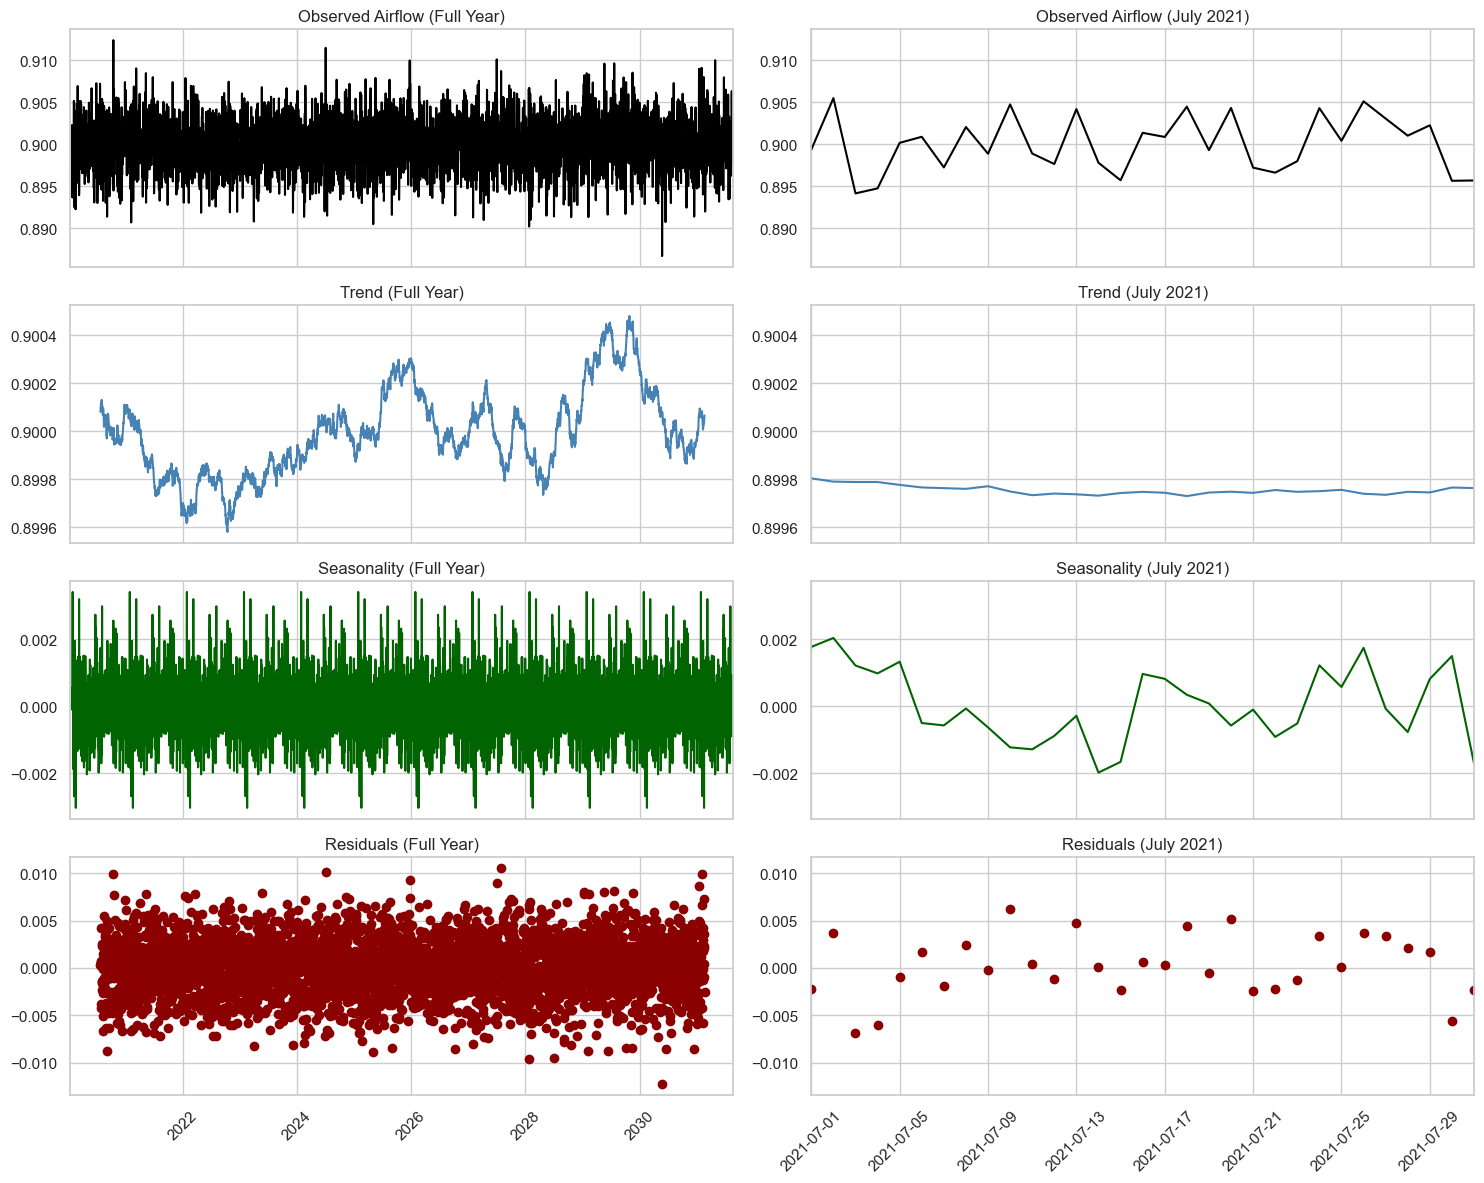

In [31]:
# Decompose airflow time series
decomposition = seasonal_decompose(daily_data['airflow'], model='additive', period=365)

observed = decomposition.observed
trend = decomposition.trend
seasonal = decomposition.seasonal
resid = decomposition.resid

# Define time ranges
full_range_start = min(daily_data.index) - pd.Timedelta(days=10)    # Start of full time range
full_range_end = max(daily_data.index)     # End of full time range
zoom_start = pd.Timestamp('2021-07-01')       # Start of zoomed month
zoom_end = pd.Timestamp('2021-07-31')           # End of zoomed month

# Create subplot layout: 4 rows (Observed, Trend, Seasonal, Residual), 2 columns (Full Year, July)
fig, axes = plt.subplots(4, 2, figsize=(15, 12), sharex='col')

# Plot: Observed
axes[0, 0].plot(observed, color='black')
axes[0, 0].set_xlim(full_range_start, full_range_end)
axes[0, 0].set_title('Observed Airflow (Full Year)')

axes[0, 1].plot(observed, color='black')
axes[0, 1].set_xlim(zoom_start, zoom_end)
axes[0, 1].set_title('Observed Airflow (July 2021)')

# Plot: Trend
axes[1, 0].plot(trend, color='steelblue')
axes[1, 0].set_xlim(full_range_start, full_range_end)
axes[1, 0].set_title('Trend (Full Year)')

axes[1, 1].plot(trend, color='steelblue')
axes[1, 1].set_xlim(zoom_start, zoom_end)
axes[1, 1].set_title('Trend (July 2021)')

# Plot: Seasonal
axes[2, 0].plot(seasonal, color='darkgreen')
axes[2, 0].set_xlim(full_range_start, full_range_end)
axes[2, 0].set_title('Seasonality (Full Year)')

axes[2, 1].plot(seasonal, color='darkgreen')
axes[2, 1].set_xlim(zoom_start, zoom_end)
axes[2, 1].set_title('Seasonality (July 2021)')

# Plot: Residuals
axes[3, 0].scatter(resid.index, resid, color='darkred')
axes[3, 0].set_xlim(full_range_start, full_range_end)
axes[3, 0].set_title('Residuals (Full Year)')

axes[3, 1].scatter(resid.index, resid, color='darkred')
axes[3, 1].set_xlim(zoom_start, zoom_end)
axes[3, 1].set_title('Residuals (July 2021)')

# Rotate x-ticks and adjust layout
for ax in axes.flatten():
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

### Comment

- **Average airflow** is approximately **0.90**, indicating a fairly stable baseline.
- **Trend component** fluctuates only slightly, between **0.9000 and 0.9005**, suggesting **no strong upward or downward trend** over time.
- **Seasonal component** ranges between **-0.0025 and 0.0025**, which is **very small relative to the mean**. This indicates that **seasonality is weak or negligible**.
- **Residual component** falls within **-0.01 to 0.01**, showing **low noise and variability** after removing trend and seasonality.

**Conclusion:**  
The airflow signal is **remarkably stable** over time, with **minimal trend or seasonal fluctuations**. This suggests that airflow is **not strongly influenced by seasonal cycles**, and may be more dependent on immediate control settings or constant operational behavior rather than environmental factors.


### Explore Solar Radiation Seasonality

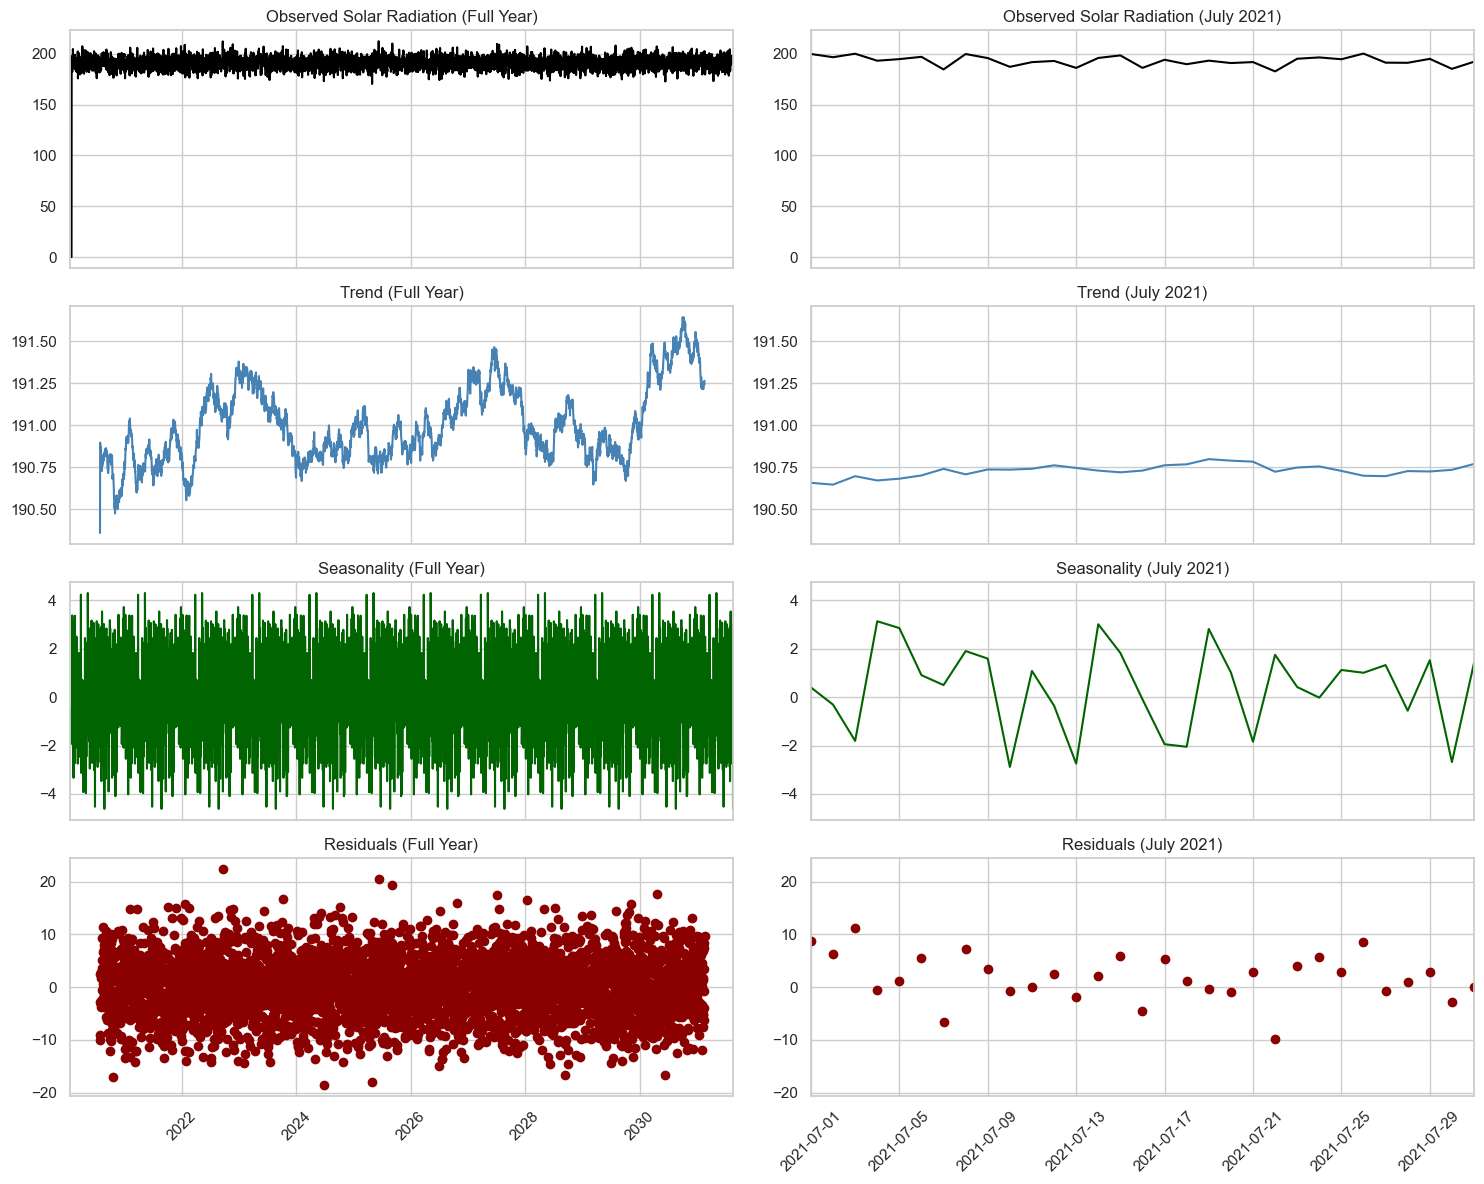

In [32]:
# Decompose supply temperature time series
decomposition = seasonal_decompose(daily_data['solar_radiation'], model='additive', period=365)

observed = decomposition.observed
trend = decomposition.trend
seasonal = decomposition.seasonal
resid = decomposition.resid

# Define time ranges
full_range_start = min(daily_data.index)- pd.Timedelta(days=10)   # Start of full time range
full_range_end = max(daily_data.index)     # End of full time range
zoom_start = pd.Timestamp('2021-07-01')         # Start of zoomed month
zoom_end = pd.Timestamp('2021-07-31')           # End of zoomed month

# Create subplot layout: 4 rows (Observed, Trend, Seasonal, Residual), 2 columns (Full Year, July)
fig, axes = plt.subplots(4, 2, figsize=(15, 12), sharex='col')

# Plot: Observed
axes[0, 0].plot(observed, color='black')
axes[0, 0].set_xlim(full_range_start, full_range_end)
axes[0, 0].set_title('Observed Solar Radiation (Full Year)')

axes[0, 1].plot(observed, color='black')
axes[0, 1].set_xlim(zoom_start, zoom_end)
axes[0, 1].set_title('Observed Solar Radiation (July 2021)')

# Plot: Trend
axes[1, 0].plot(trend, color='steelblue')
axes[1, 0].set_xlim(full_range_start, full_range_end)
axes[1, 0].set_title('Trend (Full Year)')

axes[1, 1].plot(trend, color='steelblue')
axes[1, 1].set_xlim(zoom_start, zoom_end)
axes[1, 1].set_title('Trend (July 2021)')

# Plot: Seasonal
axes[2, 0].plot(seasonal, color='darkgreen')
axes[2, 0].set_xlim(full_range_start, full_range_end)
axes[2, 0].set_title('Seasonality (Full Year)')

axes[2, 1].plot(seasonal, color='darkgreen')
axes[2, 1].set_xlim(zoom_start, zoom_end)
axes[2, 1].set_title('Seasonality (July 2021)')

# Plot: Residuals
axes[3, 0].scatter(resid.index, resid, color='darkred')
axes[3, 0].set_xlim(full_range_start, full_range_end)
axes[3, 0].set_title('Residuals (Full Year)')

axes[3, 1].scatter(resid.index, resid, color='darkred')
axes[3, 1].set_xlim(zoom_start, zoom_end)
axes[3, 1].set_title('Residuals (July 2021)')

# Rotate x-ticks and adjust layout
for ax in axes.flatten():
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

### Comment

- The **first graph** reveals the presence of a **notable outlier** in the solar radiation variable. While this anomaly is somewhat visible at the original 15-minute granularity, it becomes **much more pronounced** after aggregating the data to a **daily level**, where it stands out from the typical values.

- Upon decomposing the daily solar radiation data:
  - The **trend component** lies between **190.5 and 191.5**, suggesting a **relatively stable long-term pattern** in solar radiation, with no significant upward or downward movement over the observed period.
  - The **seasonal component** fluctuates between **-5 and +5**, indicating the presence of **mild seasonality**, possibly driven by day-night cycles or weather patterns. However, the seasonal variation is **modest relative to the overall signal**.
  - The **residuals** range between **-20 and +20**, and are **centered around 0**, reflecting **random short-term fluctuations** after accounting for trend and seasonality. The spread of residuals is **moderate**, except for the aforementioned outlier, which likely causes a spike.

**Conclusion:**  
The solar radiation variable shows **low to moderate seasonality**, a **steady trend**, and **some random noise**, with an **obvious outlier** that should be considered during further modeling. Outlier handling or smoothing may be necessary before applying forecasting models to ensure robustness and accuracy.


### Explore Occupancy Variable's Seasonality

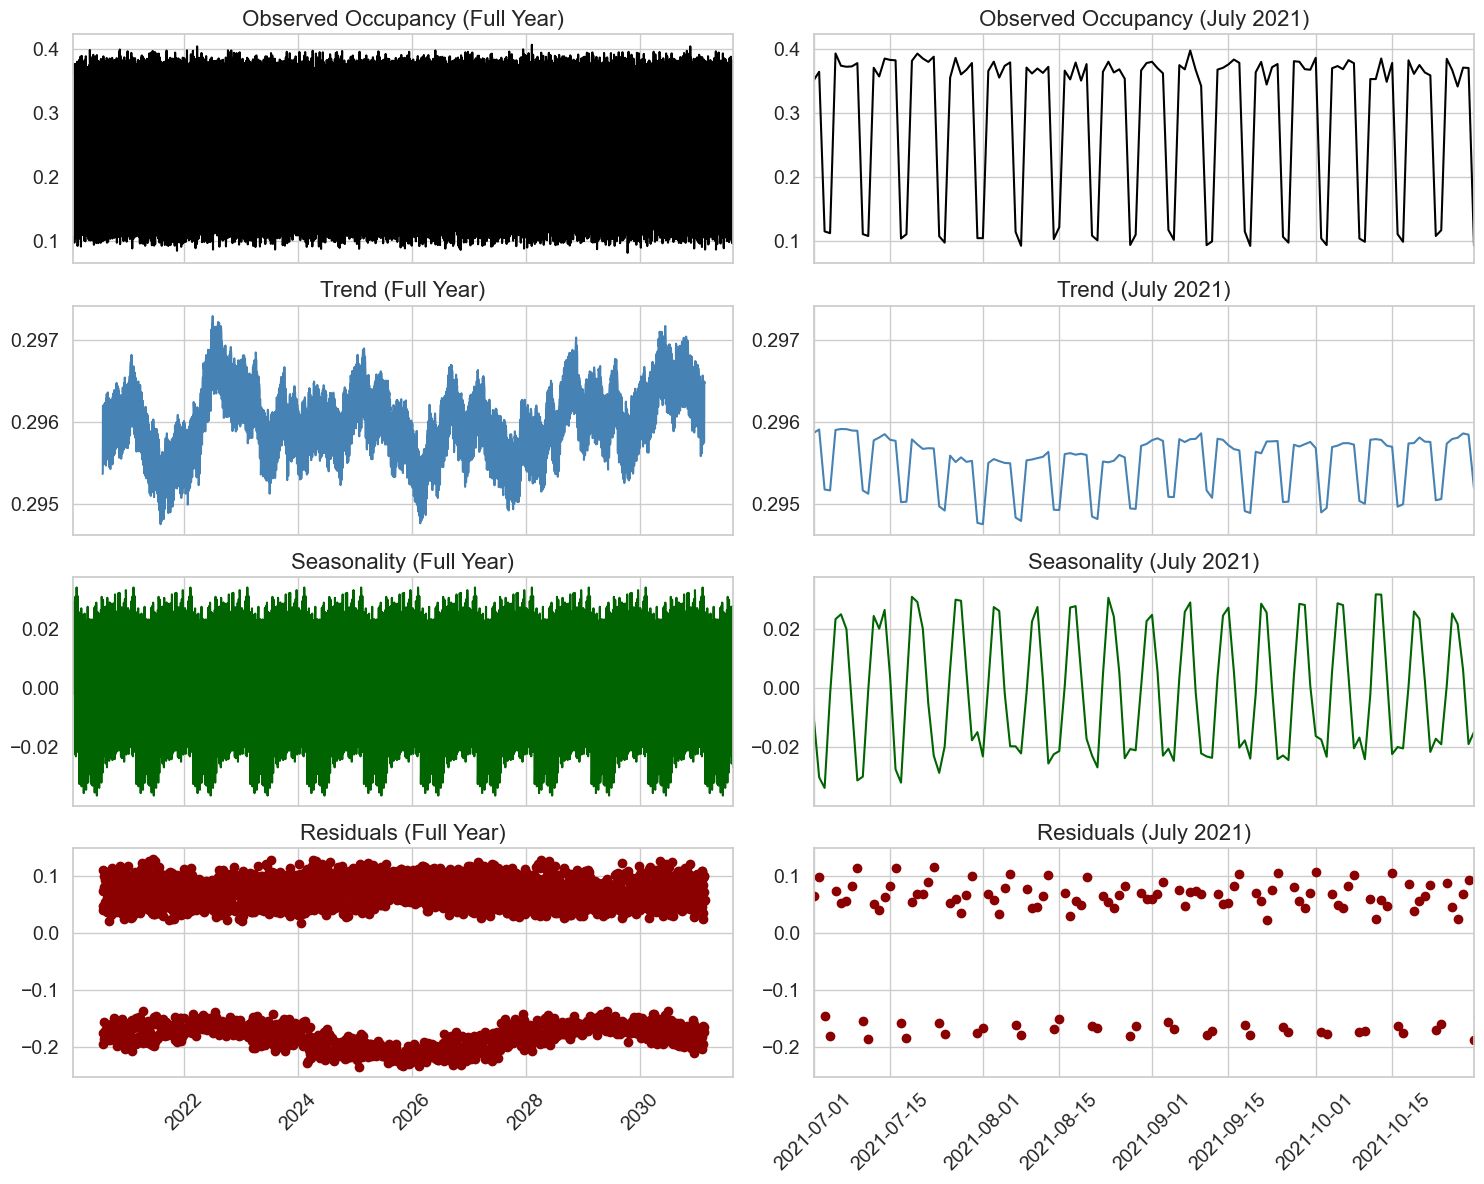

In [33]:
# Decompose supply temperature time series
decomposition = seasonal_decompose(daily_data['occupancy'], model='additive', period=365)

observed = decomposition.observed
trend = decomposition.trend
seasonal = decomposition.seasonal
resid = decomposition.resid

# Define time ranges
full_range_start = min(daily_data.index) - pd.Timedelta(days=10)   # Start of full time range
full_range_end = max(daily_data.index)     # End of full time range
zoom_start = pd.Timestamp('2021-07-01')         # Start of zoomed month
zoom_end = pd.Timestamp('2021-10-30')           # End of zoomed month

# Create subplot layout: 4 rows (Observed, Trend, Seasonal, Residual), 2 columns (Full Year, July)
fig, axes = plt.subplots(4, 2, figsize=(15, 12), sharex='col')

# Plot: Observed
axes[0, 0].plot(observed, color='black')
axes[0, 0].set_xlim(full_range_start, full_range_end)
axes[0, 0].set_title('Observed Occupancy (Full Year)')

axes[0, 1].plot(observed, color='black')
axes[0, 1].set_xlim(zoom_start, zoom_end)
axes[0, 1].set_title('Observed Occupancy (July 2021)')

# Plot: Trend
axes[1, 0].plot(trend, color='steelblue')
axes[1, 0].set_xlim(full_range_start, full_range_end)
axes[1, 0].set_title('Trend (Full Year)')

axes[1, 1].plot(trend, color='steelblue')
axes[1, 1].set_xlim(zoom_start, zoom_end)
axes[1, 1].set_title('Trend (July 2021)')

# Plot: Seasonal
axes[2, 0].plot(seasonal, color='darkgreen')
axes[2, 0].set_xlim(full_range_start, full_range_end)
axes[2, 0].set_title('Seasonality (Full Year)')

axes[2, 1].plot(seasonal, color='darkgreen')
axes[2, 1].set_xlim(zoom_start, zoom_end)
axes[2, 1].set_title('Seasonality (July 2021)')

# Plot: Residuals
axes[3, 0].scatter(resid.index, resid, color='darkred')
axes[3, 0].set_xlim(full_range_start, full_range_end)
axes[3, 0].set_title('Residuals (Full Year)')

axes[3, 1].scatter(resid.index, resid, color='darkred')
axes[3, 1].set_xlim(zoom_start, zoom_end)
axes[3, 1].set_title('Residuals (July 2021)')

# Rotate x-ticks and adjust layout
for ax in axes.flatten():
    ax.tick_params(axis='x', rotation=45)

font_size =16
axes[0, 0].set_title('Observed Occupancy (Full Year)', fontsize=font_size)
axes[0, 1].set_title('Observed Occupancy (July 2021)', fontsize=font_size)
axes[1, 0].set_title('Trend (Full Year)', fontsize=font_size)
axes[1, 1].set_title('Trend (July 2021)', fontsize=font_size)
axes[2, 0].set_title('Seasonality (Full Year)', fontsize=font_size)
axes[2, 1].set_title('Seasonality (July 2021)', fontsize=font_size)
axes[3, 0].set_title('Residuals (Full Year)', fontsize=font_size)
axes[3, 1].set_title('Residuals (July 2021)', fontsize=font_size)

for ax in axes.flatten():
    ax.tick_params(axis='x', labelsize=14, rotation=45)
    ax.tick_params(axis='y', labelsize=14)

plt.tight_layout()
plt.show()

### Occupancy Analysis (Daily Aggregated Data)

- In the **daily HVAC dataset**, the **occupancy variable** varies between **0.10 and 0.40**, indicating that it may represent a **normalized or scaled measure** of occupancy rather than a raw count. The relatively narrow range suggests **partial occupancy levels** across the system rather than binary presence/absence.

- After decomposing the time series:
  - The **trend component** fluctuates slightly between 0.295 and 0.297 but relatively flat.
  - The **seasonal component** oscillates between **-0.025 and +0.025**, pointing to the presence of **low-amplitude weekly seasonality**.
  - The **residual component** shows a **bimodal pattern**, with values clustering around **-0.25** and **+0.10**. This could suggest:
    - **Regime changes** in occupancy behavior (e.g., weekdays vs. holidays),
    - **Uncaptured dynamics** not explained by the trend or seasonality,
    - Or potential issues like **sensor noise** or preprocessing artifacts.

**Conclusion:**  
The decomposition indicates that occupancy follows a cyclic pattern: the trend is stable, and both the seasonal and residual components show repeating waveforms not tied to fixed calendar intervals. This behavior likely reflects cyclic usage dynamics of the space (e.g., alternating periods of high/low activity) rather than strict time-based seasonality.


### Explore Price Variable's Seasonality

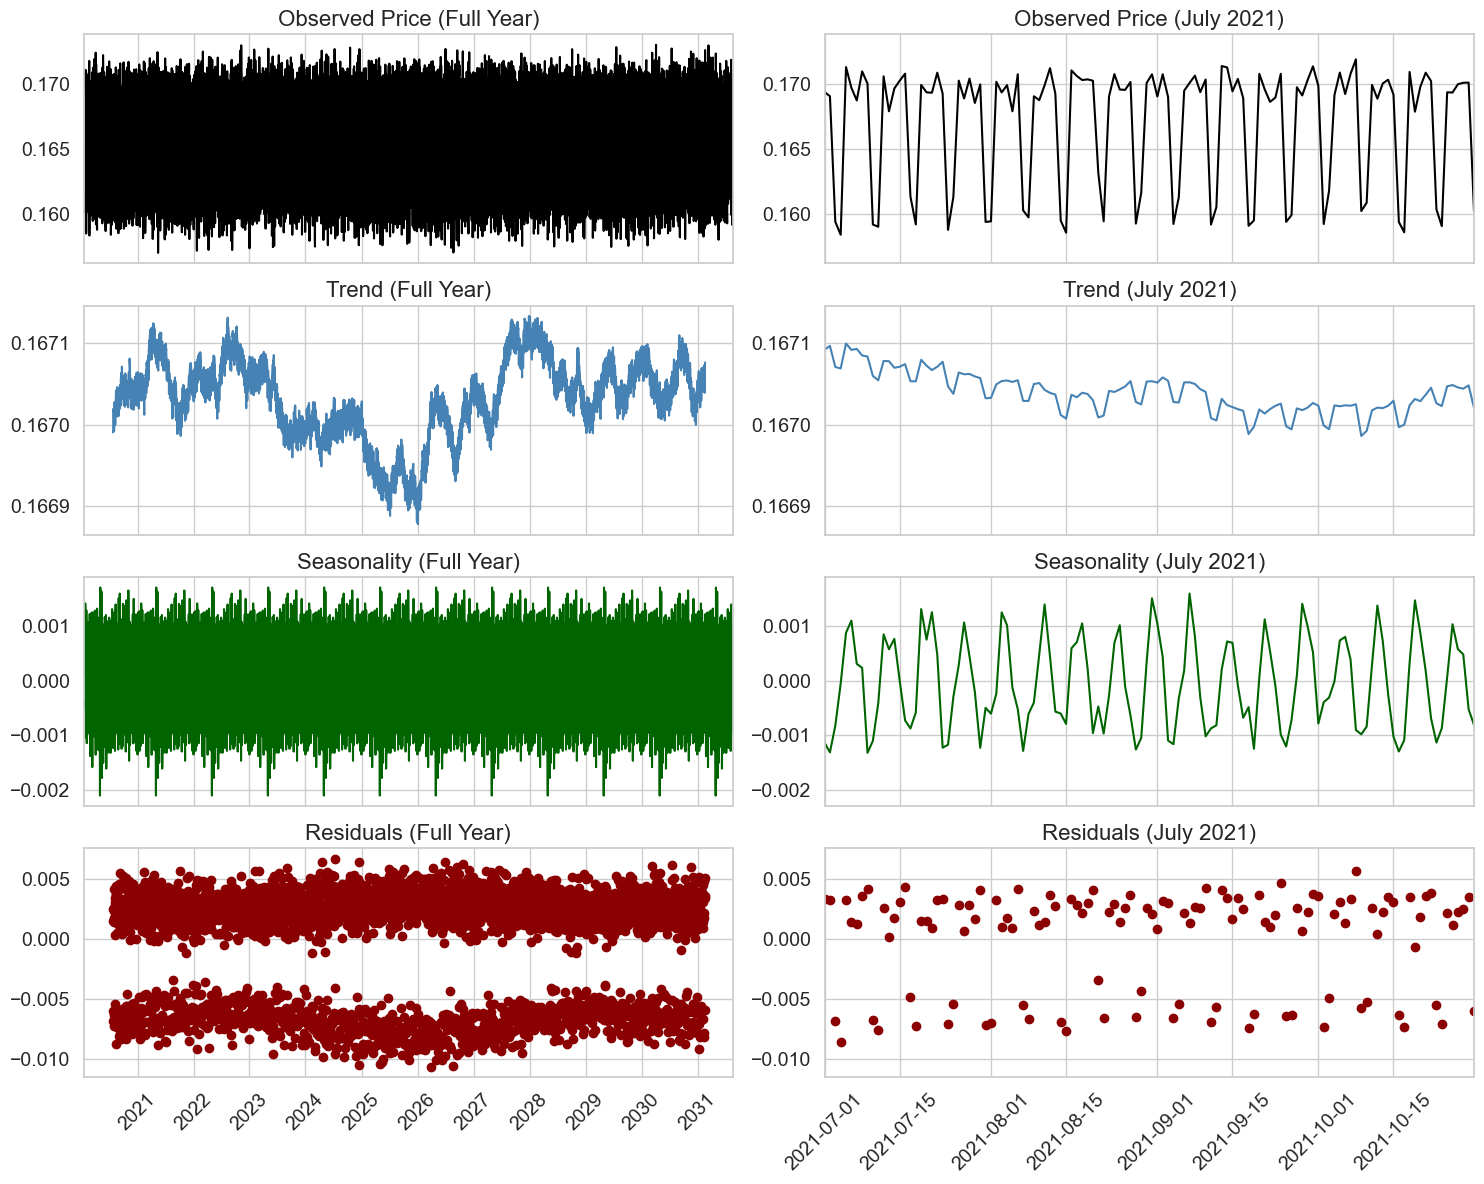

In [34]:
# Decompose supply temperature time series
decomposition = seasonal_decompose(daily_data['price'], model='additive', period=365)

observed = decomposition.observed
trend = decomposition.trend
seasonal = decomposition.seasonal
resid = decomposition.resid

# Define time ranges
full_range_start = min(daily_data.index) - pd.Timedelta(days=10)   # Start of full time range
full_range_end = max(daily_data.index)     # End of full time range
zoom_start = pd.Timestamp('2021-07-01')         # Start of zoomed month
zoom_end = pd.Timestamp('2021-10-30')           # End of zoomed month

# Create subplot layout: 4 rows (Observed, Trend, Seasonal, Residual), 2 columns (Full Year, July)
fig, axes = plt.subplots(4, 2, figsize=(15, 12), sharex='col')

# Plot: Observed
axes[0, 0].plot(observed, color='black')
axes[0, 0].set_xlim(full_range_start, full_range_end)
axes[0, 0].set_title('Observed Price (Full Year)')
axes[0, 0].set_xticks(ticks=years, labels=[str(year.year) for year in years], rotation=45)

axes[0, 1].plot(observed, color='black')
axes[0, 1].set_xlim(zoom_start, zoom_end)
axes[0, 1].set_title('Observed Price (July 2021)')

# Plot: Trend
axes[1, 0].plot(trend, color='steelblue')
axes[1, 0].set_xlim(full_range_start, full_range_end)
axes[1, 0].set_title('Trend (Full Year)')

axes[1, 1].plot(trend, color='steelblue')
axes[1, 1].set_xlim(zoom_start, zoom_end)
axes[1, 1].set_title('Trend (July 2021)')

# Plot: Seasonal
axes[2, 0].plot(seasonal, color='darkgreen')
axes[2, 0].set_xlim(full_range_start, full_range_end)
axes[2, 0].set_title('Seasonality (Full Year)')

axes[2, 1].plot(seasonal, color='darkgreen')
axes[2, 1].set_xlim(zoom_start, zoom_end)
axes[2, 1].set_title('Seasonality (July 2021)')

# Plot: Residuals
axes[3, 0].scatter(resid.index, resid, color='darkred')
axes[3, 0].set_xlim(full_range_start, full_range_end)
axes[3, 0].set_title('Residuals (Full Year)')


axes[3, 1].scatter(resid.index, resid, color='darkred')
axes[3, 1].set_xlim(zoom_start, zoom_end)
axes[3, 1].set_title('Residuals (July 2021)')
# Rotate x-ticks and adjust layout
for ax in axes.flatten():
    ax.tick_params(axis='x', rotation=45)


# Example title with larger font
font_size = 16
axes[0, 0].set_title('Observed Price (Full Year)', fontsize=font_size)

# Apply to all set_title calls
axes[0, 1].set_title('Observed Price (July 2021)', fontsize=font_size)
axes[1, 0].set_title('Trend (Full Year)', fontsize=font_size)
axes[1, 1].set_title('Trend (July 2021)', fontsize=font_size)
axes[2, 0].set_title('Seasonality (Full Year)', fontsize=font_size)
axes[2, 1].set_title('Seasonality (July 2021)', fontsize=font_size)
axes[3, 0].set_title('Residuals (Full Year)', fontsize=font_size)
axes[3, 1].set_title('Residuals (July 2021)', fontsize=font_size)


for ax in axes.flatten():
    ax.tick_params(axis='x', labelsize=14, rotation=45)
    ax.tick_params(axis='y', labelsize=14)
plt.tight_layout()
plt.show()

### Comment

- The **overall price values** range between **0.16 and 0.17**, showing a narrow fluctuation band.
- **Trend component** fluctuates between **0.1669 and 0.1671**, which is an extremely small range. This indicates that there is **no significant long-term trend** — the price remains relatively stable over time.
- **Seasonal component** is **centered around zero**, shows weekly seasonality.
- **Residual component** forms **two distinct regions**:
  - One cluster is **slightly above zero**.
  - The other is **centered around -0.005**.

This may indicate **asymmetry** or **unexplained variation** not captured by trend or seasonality.

### Explore Heating Demand Variable's Seasonality

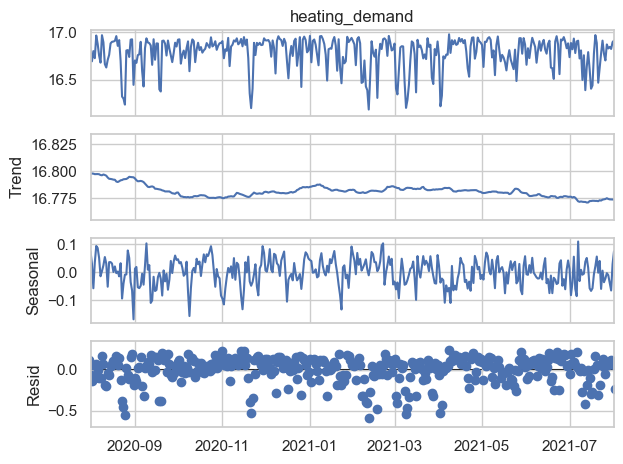

In [35]:
# Perform a time series decomposition into the trend, seasonality, and residuals¶
decomposition_heating_demand= seasonal_decompose(daily_data['heating_demand'], model='additive', period=365)
decomposition_heating_demand.plot()
#plt.xticks(ticks=years, labels=[str(year.year) for year in years], rotation=45)
plt.xlim(pd.Timestamp('2020-08-01'), pd.Timestamp('2021-08-01'))
plt.show()

### Comment 

- The **heating demand** ranges between **16 and 17**, indicating relatively stable consumption.
- **Trend component** fluctuates between **16.775 and 16.825**, suggesting **no trend**
- **Seasonal component** varies **regularly between -0.1 and 0.1**, indicating a **consistent seasonal pattern**, possibly influenced by daily or weekly temperature cycles.
- **Residual component** is **mostly concentrated below zero**, particularly around **-0.5**, which may suggest the model slightly **overestimates the heating demand** in certain periods.

Further investigation might be needed to understand the negative bias in residuals.


### Summary of Exploratory Analysis on Power Usage

The daily power usage, which is our target variable, exhibits **no strong seasonal patterns** and remains relatively **stable** throughout the year.

While power usage fluctuates slightly—rising or falling by approximately **±2.5 units**—this indicates only a **mild seasonal effect** (e.g., marginally higher consumption in winter or summer).

Overall, power demand remains **fairly steady** without significant seasonal swings.

Regarding the predictors:
- **Supply temperature, airflow, solar radiation, occupancy, price, and heating demand** do **not** show clear seasonal patterns or pronounced trends.
- **Outdoor temperature**, however, displays a **distinct seasonal pattern**, reflecting expected yearly climatic cycles.


## Summary: Prediction of Daily Power Usage

The exploratory analysis indicates that the **daily power usage** variable exhibits **no clear seasonal pattern or trend**. While there is a slight fluctuation in usage—varying by approximately ±2.5 units throughout the year—this suggests only a **minor seasonal effect**, possibly due to increased HVAC usage during temperature extremes in summer and winter. However, these variations are relatively small, and the overall power demand remains **consistently stable over time**.

Statistical diagnostics, including the **Autocorrelation Function (ACF)**, **Partial Autocorrelation Function (PACF)**, and the **Ljung-Box test**, reveal **no significant autocorrelation or partial autocorrelation** in the daily aggregated data. This suggests that **each day's power usage is largely independent** of previous days and does not exhibit serial dependence, a key assumption for many time series forecasting models.

In addition, the majority of predictor variables—such as **solar_radiation**, **supply temperature**, and **airflow**—also demonstrate **stable behavior** with no significant trends or seasonal variation at the daily level. The **outdoor temperature** is the only feature that shows a recognizable seasonal cycle, as expected. **price** and **occupancy** shows weekly seasonality but as residuals in price and occupancy does not show normal distibution, unexplained variation not captured by trend or seasonality.

Given the lack of autocorrelation, trend, or strong seasonal signals in the daily data, I have decided to continue the analysis by examining **more granular power usage data at the 15-minute level**. This finer resolution may reveal **intra-day patterns**, **short-term dependencies**, or **daily cyclic behaviors** that are not observable in the aggregated daily data.


# Feature Engineering

In [36]:
# Seasonal encoding for outdoor temperature (annual cycle)
daily_data['day_of_year'] = daily_data.index.dayofyear
daily_data['sin_day'] = np.sin(2 * np.pi * daily_data['day_of_year'] / 365)  # mapping the day onto a circular scale (0 to 2π).
daily_data['cos_day'] = np.cos(2 * np.pi * daily_data['day_of_year'] / 365)  # mapping the day onto a circular scale (0 to 2π).

In [37]:
# Rolling mean of price and occupancy over last 7 days
daily_data['price_roll_7'] = daily_data['price'].rolling(window=7).mean()
daily_data['occupancy_roll_7'] = daily_data['occupancy'].rolling(window=7).mean()

In [38]:
daily_data.dropna(inplace=True)
daily_data.head()

,supply_temp,outdoor_temp,airflow,power_usage,solar_radiation,occupancy,price,heating_demand,day_of_year,sin_day,cos_day,price_roll_7,occupancy_roll_7
timestamp,,,,,,,,,,,,,
2020-01-31,-0.920789,8.804636,0.901104,1553.165029,198.064502,0.367130,0.168795,16.919485,31,0.508671,0.860961,0.167109,0.291495
2020-02-01,-0.768226,9.124907,0.900719,1549.441555,197.087668,0.104071,0.158532,16.768325,32,0.523416,0.852078,0.166837,0.291205
2020-02-02,-0.920986,9.200300,0.899920,1547.118258,192.736376,0.108135,0.160951,16.922115,33,0.538005,0.842942,0.166953,0.292727
2020-02-03,-0.815759,9.015627,0.898827,1548.693847,204.757993,0.371409,0.169984,16.816692,34,0.552435,0.833556,0.166991,0.294033
2020-02-04,-0.916265,9.210312,0.901790,1555.014685,186.513532,0.376197,0.170620,16.915793,35,0.566702,0.823923,0.166930,0.294022


In [39]:
# check if the created features have high correlation 
daily_data.corr()

,supply_temp,outdoor_temp,airflow,power_usage,solar_radiation,occupancy,price,heating_demand,day_of_year,sin_day,cos_day,price_roll_7,occupancy_roll_7
supply_temp,1.000000,0.049720,-0.015377,0.016924,-0.006920,0.012389,0.011464,-0.999866,0.019456,-0.020984,-0.054672,0.047206,0.031976
outdoor_temp,0.049720,1.000000,-0.003994,-0.000280,-0.007613,-0.001012,-0.002345,-0.049727,-0.135372,0.169547,-0.983950,-0.028714,-0.043609
airflow,-0.015377,-0.003994,1.000000,0.129639,0.026723,0.004122,0.002865,0.015128,0.019530,-0.021573,0.000516,-0.018240,-0.003686
power_usage,0.016924,-0.000280,0.129639,1.000000,0.009677,0.021125,0.021766,-0.016545,0.008501,-0.022281,-0.004072,-0.018118,-0.039056
solar_radiation,-0.006920,-0.007613,0.026723,0.009677,1.000000,0.004535,0.002703,0.006728,0.006522,-0.017167,0.005600,0.013112,0.000091
occupancy,0.012389,-0.001012,0.004122,0.021125,0.004535,1.000000,0.971601,-0.012479,0.001184,-0.000280,0.001048,-0.000114,0.030880
price,0.011464,-0.002345,0.002865,0.021766,0.002703,0.971601,1.000000,-0.011545,-0.000021,0.005208,0.003255,0.083760,-0.005561
heating_demand,-0.999866,-0.049727,0.015128,-0.016545,0.006728,-0.012479,-0.011545,1.000000,-0.019483,0.020971,0.054672,-0.047273,-0.032000
day_of_year,0.019456,-0.135372,0.019530,0.008501,0.006522,0.001184,-0.000021,-0.019483,1.000000,-0.782183,-0.001502,-0.015144,0.018058
sin_day,-0.020984,0.169547,-0.021573,-0.022281,-0.017167,-0.000280,0.005208,0.020971,-0.782183,1.000000,0.005181,0.069818,0.000480


In [40]:
daily_data.drop(['power_usage'], axis=1)

,supply_temp,outdoor_temp,airflow,solar_radiation,occupancy,price,heating_demand,day_of_year,sin_day,cos_day,price_roll_7,occupancy_roll_7
timestamp,,,,,,,,,,,,
2020-01-31,-0.920789,8.804636,0.901104,198.064502,0.367130,0.168795,16.919485,31,0.508671,0.860961,0.167109,0.291495
2020-02-01,-0.768226,9.124907,0.900719,197.087668,0.104071,0.158532,16.768325,32,0.523416,0.852078,0.166837,0.291205
2020-02-02,-0.920986,9.200300,0.899920,192.736376,0.108135,0.160951,16.922115,33,0.538005,0.842942,0.166953,0.292727
2020-02-03,-0.815759,9.015627,0.898827,204.757993,0.371409,0.169984,16.816692,34,0.552435,0.833556,0.166991,0.294033
2020-02-04,-0.916265,9.210312,0.901790,186.513532,0.376197,0.170620,16.915793,35,0.566702,0.823923,0.166930,0.294022
...,...,...,...,...,...,...,...,...,...,...,...,...
2031-08-16,-0.796151,19.880038,0.899950,197.243818,0.096384,0.160295,16.801045,228,-0.705584,-0.708627,0.166851,0.293147
2031-08-17,-0.805539,19.493686,0.897895,192.432448,0.119333,0.159176,16.806690,229,-0.717677,-0.696376,0.166741,0.295690
2031-08-18,-0.683561,19.566741,0.902638,198.553443,0.360844,0.170411,16.675136,230,-0.729558,-0.683919,0.167068,0.296949


In [41]:
X = daily_data.drop(['power_usage'], axis=1)
y = daily_data['power_usage']

# Modeling

Linear Regression - MAE: 3.283, RMSE: 4.098, R2: 0.011


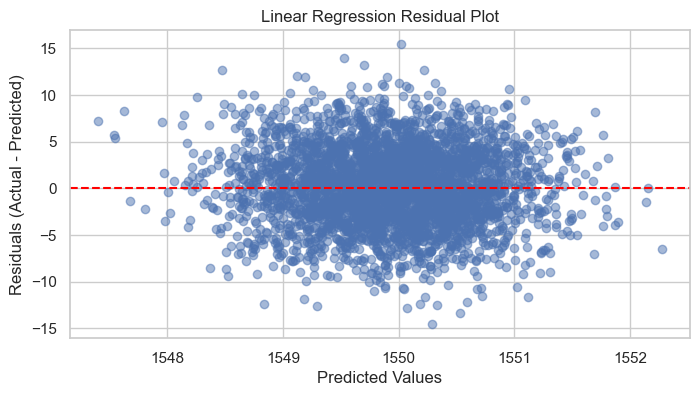

Gradient Boosting - MAE: 3.335, RMSE: 4.159, R2: -0.018


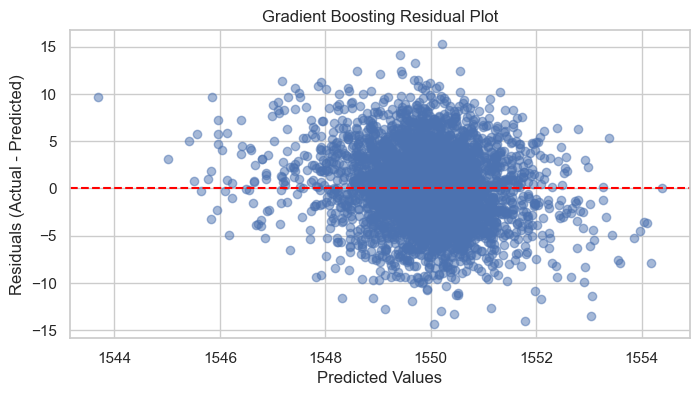

Random Forest - MAE: 3.355, RMSE: 4.189, R2: -0.033


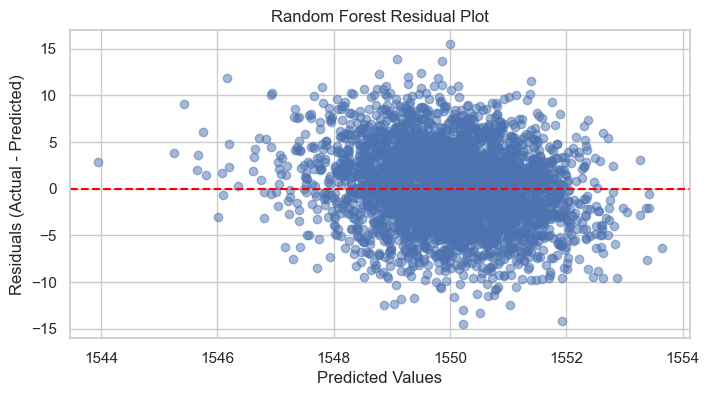

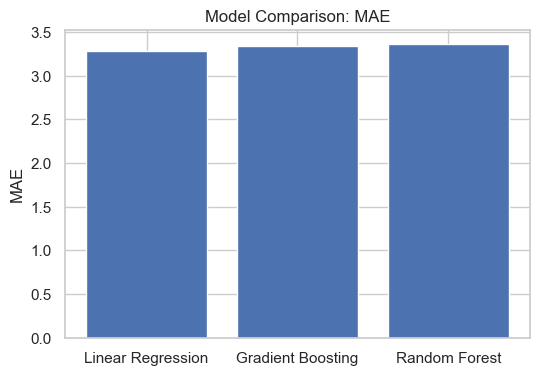

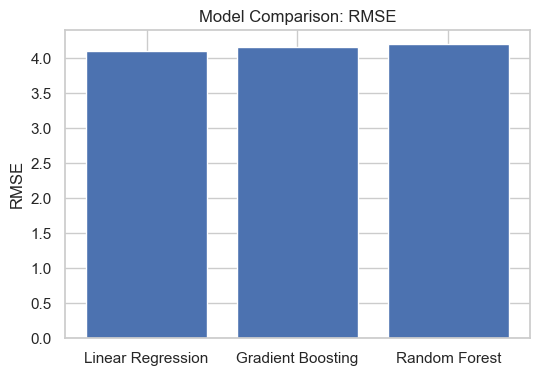

In [42]:
tscv = TimeSeriesSplit(n_splits=5)

models = {
    'Linear Regression': LinearRegression(),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100),
    'Random Forest': RandomForestRegressor(n_estimators=100)
}

results = {}

for name, model in models.items():
    maes, rmses, r2s = [], [], []
    all_residuals = []
    all_y_test = []
    all_preds = []
    
    for train_idx, test_idx in tscv.split(X):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        model.fit(X_train, y_train)
        preds = model.predict(X_test)

        maes.append(mean_absolute_error(y_test, preds))
        rmses.append(mean_squared_error(y_test, preds, squared=False))
        r2s.append(r2_score(y_test, preds))
        
        all_residuals.extend(y_test - preds)
        all_y_test.extend(y_test)
        all_preds.extend(preds)
    
    results[name] = {
        'RMSE': np.mean(rmses),
        'R2': np.mean(r2s),
        'MAE': np.mean(maes)
    }
    
    print(f"{name} - MAE: {results[name]['MAE']:.3f}, RMSE: {results[name]['RMSE']:.3f}, R2: {results[name]['R2']:.3f}")

    # Residual plot
    plt.figure(figsize=(8,4))
    plt.scatter(all_preds, all_residuals, alpha=0.5)
    plt.axhline(0, color='red', linestyle='--')
    plt.title(f"{name} Residual Plot")
    plt.xlabel("Predicted Values")
    plt.ylabel("Residuals (Actual - Predicted)")
    plt.show()

# Summary bar plot for MAE and RMSE
metrics_to_plot = ['MAE', 'RMSE']
for metric in metrics_to_plot:
    plt.figure(figsize=(6,4))
    plt.bar(results.keys(), [results[m][metric] for m in results])
    plt.title(f'Model Comparison: {metric}')
    plt.ylabel(metric)
    plt.show()

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.43 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=59183.095, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.13 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=19265.127, Time=0.34 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=19324.046, Time=0.51 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=19322.019, Time=0.12 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=inf, Time=0.41 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=19193.951, Time=0.26 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=19191.996, Time=0.08 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=19191.014, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=19191.943, Time=0.20 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 2.579 seconds
MAE: 3.223


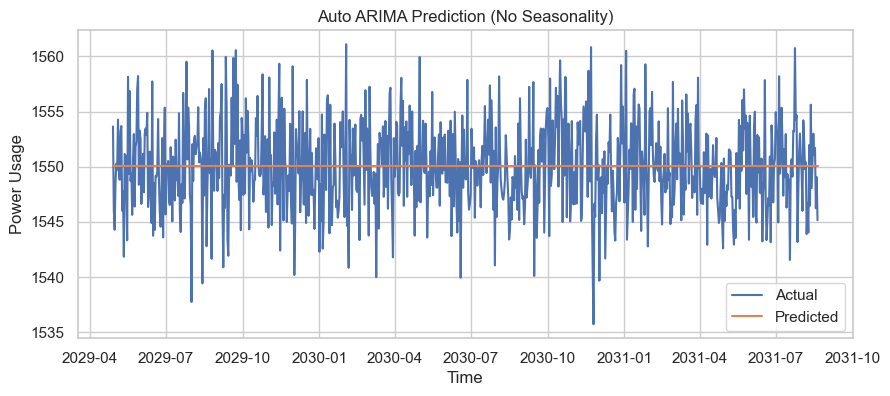

In [43]:
# Assume df is your DataFrame sorted by date
# Target variable
y = daily_data['power_usage']

# Exogenous variables (multiple features)
exog = daily_data[['supply_temp', 'outdoor_temp', 'airflow', 'solar_radiation', 'occupancy', 'price',
           'heating_demand','day_of_year', 'sin_day', 'cos_day', 'price_roll_7','occupancy_roll_7']]

# Train-test split
split_idx = int(len(daily_data) * 0.8)
y_train, y_test = y[:split_idx], y[split_idx:]
X_train, X_test = exog[:split_idx], exog[split_idx:]

# Fit auto_arima without seasonal component
model = auto_arima(
    y=y_train,
    exogenous=X_train,
    seasonal=False,       # <<< no seasonality
    stepwise=True,
    suppress_warnings=True,
    trace=True
)

# Forecast
forecast = model.predict(n_periods=len(y_test), exogenous=X_test)

# Evaluate
mae = mean_absolute_error(y_test, forecast)
print(f'MAE: {mae:.3f}')

# Visualise
plt.figure(figsize=(10, 4))
plt.plot(y_test, label='Actual')
plt.plot(forecast, label='Predicted')
plt.title('Auto ARIMA Prediction (No Seasonality)')
plt.xlabel('Time')
plt.ylabel('Power Usage')
plt.legend()
plt.show()


# OUTLOOK

## Hourly Aggregated Data

### Why Choose Hourly?

- Strikes a balance between **too coarse (daily)** and **too noisy (15-minute)** data.
- HVAC systems often follow **daily usage patterns** influenced by human activity (e.g., morning ramp-up, afternoon cooling).
- Hourly data can reveal **building occupancy trends**, such as differences between working hours and off-hours.

---

### Advantages of Hourly Aggregation

- Helps identify **workday vs. nighttime energy behavior**.
- May expose **within-day cycles**, such as increased usage during peak hours or lunch breaks.
- Provides enough resolution to apply time series models effectively, without the volatility of high-frequency data.

---


In [44]:
#Resample to hourly Means to Check Seasonality
hourly_data = hvac_raw_data.resample('H').mean()

In [45]:
hourly_data['power_usage'][:1000]

timestamp
2020-01-25 20:00:00    1559.336611
2020-01-25 21:00:00    1541.545479
2020-01-25 22:00:00    1550.291561
2020-01-25 23:00:00    1591.021154
2020-01-26 00:00:00    1545.599614
                          ...     
2020-03-07 07:00:00    1538.434272
2020-03-07 08:00:00    1532.331734
2020-03-07 09:00:00    1525.926712
2020-03-07 10:00:00    1541.659911
2020-03-07 11:00:00    1559.066121
Freq: H, Name: power_usage, Length: 1000, dtype: float64

###  Stationarity Analysis of Power Usage for hourly data

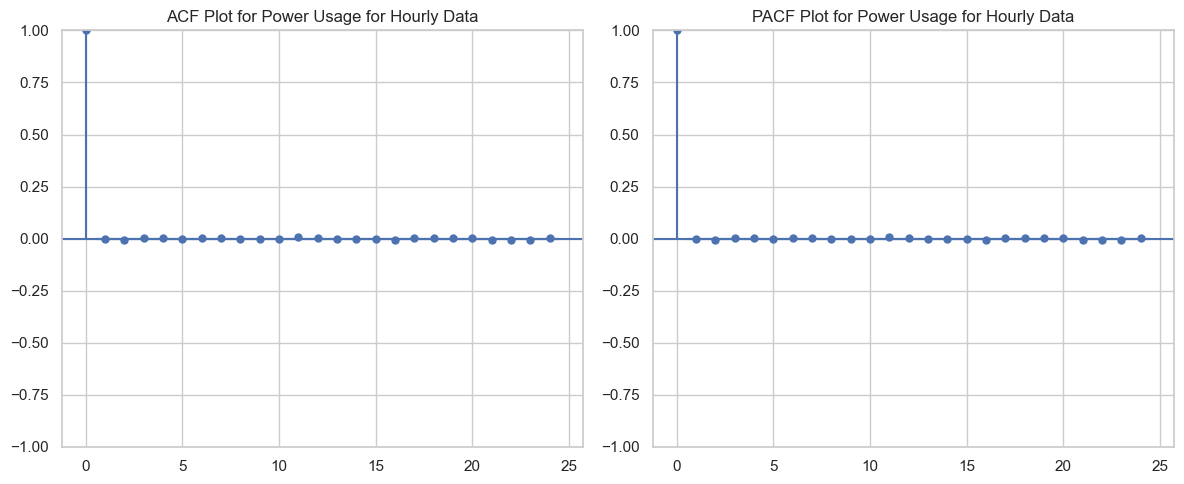

In [46]:
# Create subplots: 1 row, 2 columns for ACF and PACF
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot ACF
plot_acf(hourly_data['power_usage'], lags=24, ax=axes[0])
axes[0].set_title('ACF Plot for Power Usage for Hourly Data')

# Plot PACF
plot_pacf(hourly_data['power_usage'], lags=24, method='ywm', ax=axes[1])
axes[1].set_title('PACF Plot for Power Usage for Hourly Data')

plt.tight_layout()
plt.show()

In [47]:
# Ljung-Box test (up to lag 24)
ljung_box_result = acorr_ljungbox(hourly_data['power_usage'], lags=[24], return_df=True)
print("Ljung-Box Test Result (lag=40):")
print(ljung_box_result)

Ljung-Box Test Result (lag=40):
      lb_stat  lb_pvalue
24  25.642415   0.371555


## Modelling

In [48]:
X = hourly_data.drop(['power_usage'], axis=1)
y = hourly_data['power_usage']

Linear Regression - MAE: 16.036, RMSE: 20.035, R2: 0.021


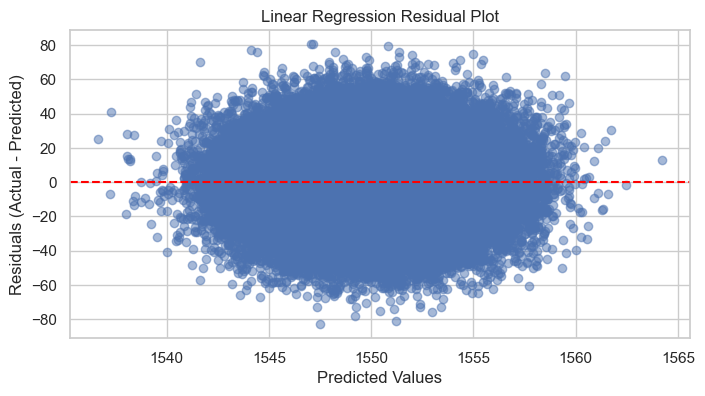

Gradient Boosting - MAE: 16.054, RMSE: 20.062, R2: 0.018


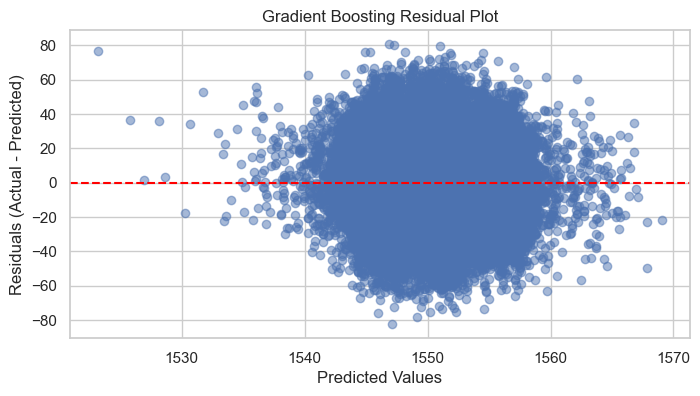

Random Forest - MAE: 16.352, RMSE: 20.426, R2: -0.018


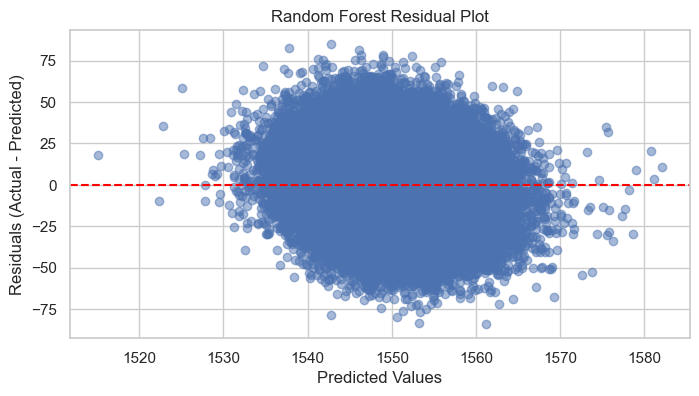

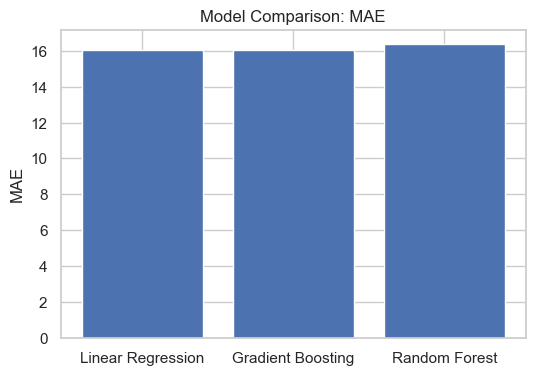

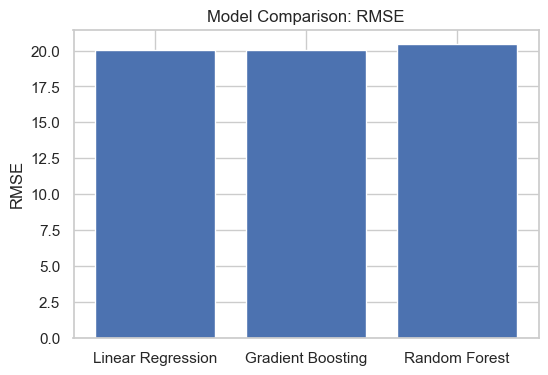

In [49]:
tscv = TimeSeriesSplit(n_splits=5)

models = {
    'Linear Regression': LinearRegression(),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100),
    'Random Forest': RandomForestRegressor(n_estimators=100)
}

results = {}

for name, model in models.items():
    maes, rmses, r2s = [], [], []
    all_residuals = []
    all_y_test = []
    all_preds = []
    
    for train_idx, test_idx in tscv.split(X):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        model.fit(X_train, y_train)
        preds = model.predict(X_test)

        maes.append(mean_absolute_error(y_test, preds))
        rmses.append(mean_squared_error(y_test, preds, squared=False))
        r2s.append(r2_score(y_test, preds))
        
        all_residuals.extend(y_test - preds)
        all_y_test.extend(y_test)
        all_preds.extend(preds)
    
    results[name] = {
        'MAE': np.mean(maes),
        'RMSE': np.mean(rmses),
        'R2': np.mean(r2s)
    }
    
    print(f"{name} - MAE: {results[name]['MAE']:.3f}, RMSE: {results[name]['RMSE']:.3f}, R2: {results[name]['R2']:.3f}")

    # Residual plot
    plt.figure(figsize=(8,4))
    plt.scatter(all_preds, all_residuals, alpha=0.5)
    plt.axhline(0, color='red', linestyle='--')
    plt.title(f"{name} Residual Plot")
    plt.xlabel("Predicted Values")
    plt.ylabel("Residuals (Actual - Predicted)")
    plt.show()

# Summary bar plot for MAE and RMSE
metrics_to_plot = ['MAE', 'RMSE']
for metric in metrics_to_plot:
    plt.figure(figsize=(6,4))
    plt.bar(results.keys(), [results[m][metric] for m in results])
    plt.title(f'Model Comparison: {metric}')
    plt.ylabel(metric)
    plt.show()

... to be continued